# Sea Level Rise Analysis

This notebook performs analysis of global mean sea level (GMSL) and global mean surface temperature (GMST)
datasets for estimating the transient sea level sensitivity parameter α.

**Data source:** All processed data are loaded from `slr_processed_data.h5`,
produced by `read_process_datafiles.ipynb`.

**Analysis Framework:**
$$\alpha = \frac{d(\text{GMSL rate})}{dT} \approx \frac{\text{GMSL acceleration}}{\text{Warming rate}}$$

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from pathlib import Path

# =============================================================================
# Paths
# =============================================================================
BASE_DIR = Path('..')
DATA_DIR = BASE_DIR / 'data'
DATA_RAW_DIR = DATA_DIR / 'raw'
DATA_IPCC_DIR = DATA_RAW_DIR / 'ipcc_ar6'
PROCESSED_FILE = DATA_DIR / 'processed' / 'slr_processed_data.h5'

SEALEVEL_UNITS = 'm'
TEMPERATURE_UNITS = 'c'
TIME_UNITS = 'y'

plt.rcParams['figure.figsize'] = (12, 6)

# =============================================================================
# Load all processed data from HDF5
# =============================================================================
store = pd.HDFStore(str(PROCESSED_FILE), mode='r')
print(f'Loaded {len(store.keys())} keys from {PROCESSED_FILE.name}')

# --- Configuration ---
config = store['config']
BASELINE = (int(config['baseline_start'].iloc[0]), int(config['baseline_end'].iloc[0]))
SPAN_YEARS = int(config['span_years'].iloc[0])
print(f'Baseline: {BASELINE}, Bandwidth: {SPAN_YEARS} yr')

# --- Raw observed DataFrames ---
df_frederikse        = store['raw/df_frederikse']
df_dangendorf        = store['raw/df_dangendorf']
df_horwath           = store['raw/df_horwath']
df_nasa_gmsl         = store['raw/df_nasa_gmsl']
df_ipcc_observed_gmsl = store['raw/df_ipcc_observed_gmsl']
df_imbie_wais        = store['raw/df_imbie_wais']
df_berkeley          = store['raw/df_berkeley']
df_hadcrut           = store['raw/df_hadcrut']
df_gistemp           = store['raw/df_gistemp']
df_noaa              = store['raw/df_noaa']

# --- Baseline-harmonized DataFrames ---
df_frederikse_h        = store['harmonized/df_frederikse_h']
df_nasa_gmsl_h         = store['harmonized/df_nasa_gmsl_h']
df_horwath_h           = store['harmonized/df_horwath_h']
df_dangendorf_h        = store['harmonized/df_dangendorf_h']
df_ipcc_observed_gmsl_h = store['harmonized/df_ipcc_observed_gmsl_h']
df_imbie_wais_h        = store['harmonized/df_imbie_wais_h']
df_berkeley_h          = store['harmonized/df_berkeley_h']
df_hadcrut_h           = store['harmonized/df_hadcrut_h']
df_gistemp_h           = store['harmonized/df_gistemp_h']
df_noaa_h              = store['harmonized/df_noaa_h']

# --- Derived DataFrames ---
df_frederikse_thermo   = store['derived/df_frederikse_thermo']
df_frederikse_thermo_h = store['derived/df_frederikse_thermo_h']

# --- IPCC Projections ---
temp_projections = {}
for scenario in ['Historical', 'SSP1_1_9', 'SSP1_2_6', 'SSP2_4_5', 'SSP3_7_0', 'SSP5_8_5']:
    temp_projections[scenario] = store[f'projections/temp/{scenario}']

ipcc_gmsl_proj = {}
for key in [k for k in store.keys() if k.startswith('/projections/gmsl/')]:
    scenario = key.split('/')[-1]
    ipcc_gmsl_proj[scenario] = store[key]

# --- Kinematics ---
kinematics_dfs = {}
for key in [k for k in store.keys() if k.startswith('/kinematics/gmsl/')]:
    name = key.split('/')[-1]
    kinematics_dfs[name] = store[key]

gmst_kinematics_dfs = {}
for key in [k for k in store.keys() if k.startswith('/kinematics/gmst/')]:
    name = key.split('/')[-1]
    gmst_kinematics_dfs[name] = store[key]

store.close()

print(f'\nRaw datasets:         {10}')
print(f'Harmonized datasets:  {10}')
print(f'Derived datasets:     {2}')
print(f'Temp projections:     {len(temp_projections)} scenarios')
print(f'GMSL projections:     {len(ipcc_gmsl_proj)} scenarios')
print(f'GMSL kinematics:      {len(kinematics_dfs)} datasets')
print(f'GMST kinematics:      {len(gmst_kinematics_dfs)} datasets')

---
## 1. Data Catalog

All datasets loaded from `slr_processed_data.h5` (produced by `read_process_datafiles.ipynb`).

### Observed Datasets

| Variable | Type | Period | Resolution | Source |
|----------|------|--------|------------|--------|
| `df_frederikse` | GMSL | 1900–2018 | Annual | Frederikse et al. (2020) |
| `df_dangendorf` | GMSL | 1900–2021 | Annual | Dangendorf et al. (2024) |
| `df_horwath` | GMSL | 1993–2016 | Monthly | Horwath et al. (2022) |
| `df_nasa_gmsl` | GMSL | 1993–2025 | 10-day | NASA GSFC Altimetry |
| `df_ipcc_observed_gmsl` | GMSL | 1950–2020 | Annual | IPCC AR6 Ch. 9 |
| `df_imbie_wais` | WAIS | 1992–2020 | Monthly | IMBIE (Otosaka et al., 2023) |
| `df_berkeley` | Temp | 1850–2024 | Monthly | Berkeley Earth |
| `df_hadcrut` | Temp | 1850–2025 | Monthly | HadCRUT5 |
| `df_gistemp` | Temp | 1880–2025 | Monthly | NASA GISTEMP v4 |
| `df_noaa` | Temp | 1850–2025 | Annual | NOAA GlobalTemp |

### Harmonized Datasets (baseline: 1995–2005)

All `_h` suffixed variables are re-baselined to the 1995–2005 reference period.

### Derived

- `df_frederikse_thermo` / `df_frederikse_thermo_h`: Thermodynamic signal = steric + barystatic − TWS

### IPCC AR6 Projections

- `temp_projections`: dict of SSP temperature scenarios (1850–1900 baseline)
- `ipcc_gmsl_proj`: dict of FACTS GMSL projection scenarios

### Kinematics

- `kinematics_dfs`: GMSL rate/acceleration from local polynomial regression
- `gmst_kinematics_dfs`: GMST rate/acceleration

In [ ]:
from slr_data_readers import datetime_to_decimal_year

def get_decimal_year(df):
    """Extract or compute decimal year from dataframe."""
    if 'decimal_year' in df.columns:
        return df['decimal_year'].values
    else:
        return np.array([datetime_to_decimal_year(t) for t in df.index])

# Quick verification of loaded data
print(f"{'Dataset':<30} {'Shape':>12}  {'Period'}")
print('-' * 75)
for name, df in [
    ('df_frederikse', df_frederikse),
    ('df_dangendorf', df_dangendorf),
    ('df_horwath', df_horwath),
    ('df_nasa_gmsl', df_nasa_gmsl),
    ('df_ipcc_observed_gmsl', df_ipcc_observed_gmsl),
    ('df_imbie_wais', df_imbie_wais),
    ('df_berkeley', df_berkeley),
    ('df_hadcrut', df_hadcrut),
    ('df_gistemp', df_gistemp),
    ('df_noaa', df_noaa),
]:
    print(f'{name:<30} {str(df.shape):>12}  {df.index.min()} — {df.index.max()}')

---
## 2. Rates and Accelerations

Pre-computed kinematics (local polynomial regression) loaded from HDF5.
Bandwidth: set by `SPAN_YEARS` in the config.

In [ ]:
# Kinematics already loaded from HDF5 as kinematics_dfs and gmst_kinematics_dfs
# Print summary
print(f"Kinematics loaded ({SPAN_YEARS}-year bandwidth)\n")
print(f"{'Dataset':<35} {'Period':<15} {'Recent Rate':<20} {'Recent Accel'}")
print('-' * 100)

for name, df in kinematics_dfs.items():
    valid_idx = ~np.isnan(df['rate'])
    if valid_idx.any():
        last_valid = df.loc[valid_idx].index[-1]
        rate = df.loc[last_valid, 'rate'] * 1000
        rate_se = df.loc[last_valid, 'rate_se'] * 1000
        accel = df.loc[last_valid, 'accel'] * 1000
        accel_se = df.loc[last_valid, 'accel_se'] * 1000
        period = f"{df.loc[valid_idx, 'decimal_year'].min():.0f}-{df.loc[valid_idx, 'decimal_year'].max():.0f}"
        print(f"{name:<35} {period:<15} {rate:>6.2f} ± {rate_se:.2f} mm/yr   {accel:>7.4f} ± {accel_se:.4f} mm/yr²")

---
---
## 6. Visualization

### 6.1 Main Overview: GMSL and Temperatures

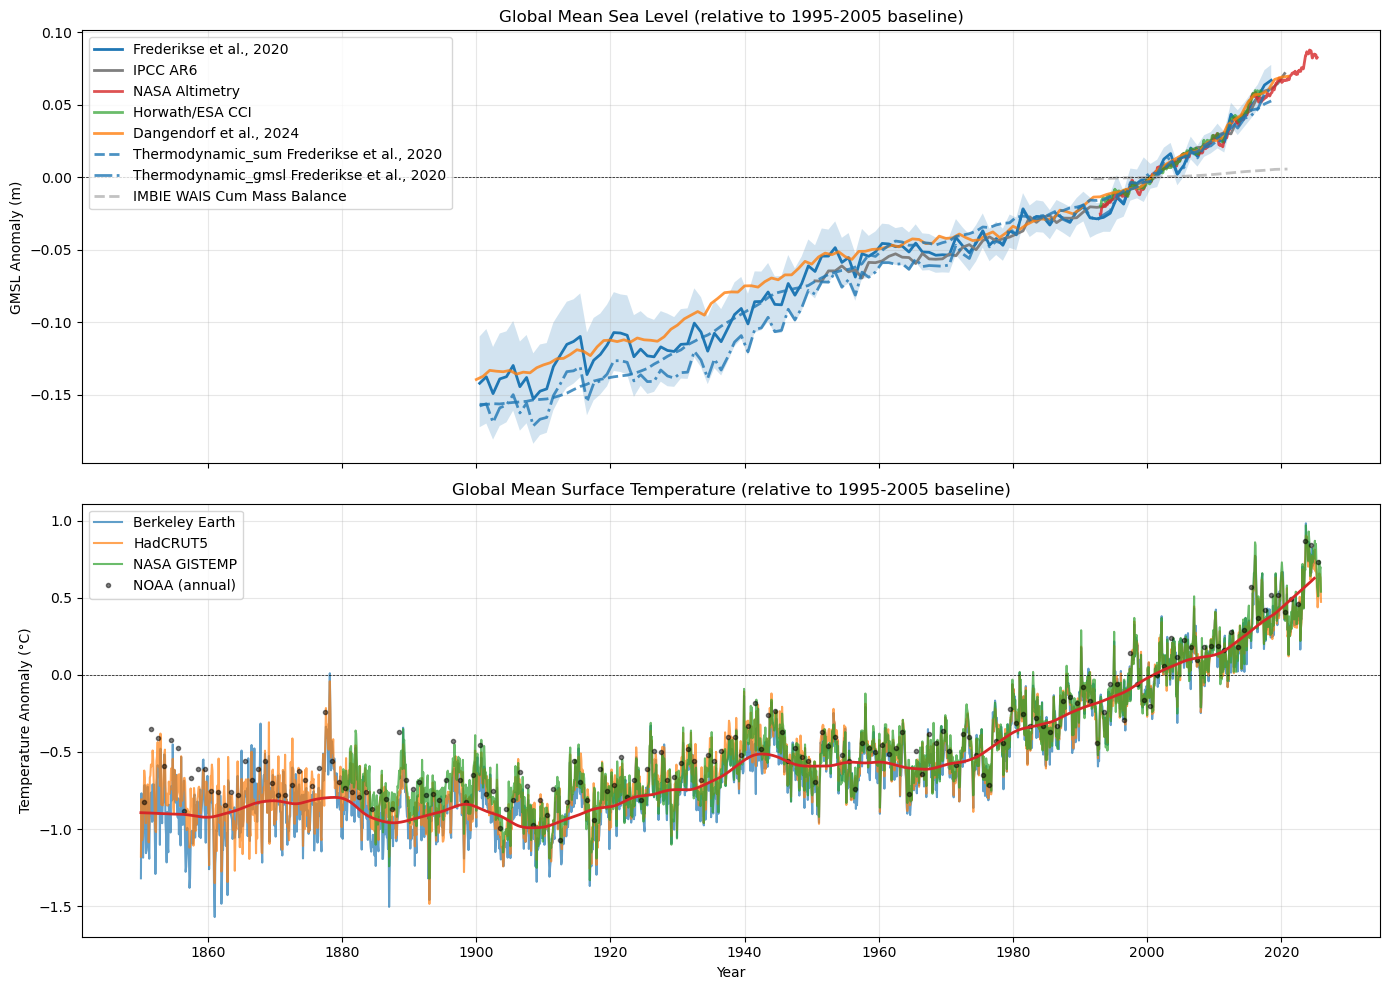

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# GMSL
ax1 = axes[0]
ax1.plot(df_frederikse_h.index, df_frederikse_h['gmsl'], 'tab:blue', lw=2, label='Frederikse et al., 2020')
ax1.fill_between(df_frederikse_h.index, df_frederikse_h['gmsl_lower'], df_frederikse_h['gmsl_upper'], alpha=0.2)
ax1.plot(df_ipcc_observed_gmsl_h.index, df_ipcc_observed_gmsl_h['gmsl'], 'tab:grey', lw=2, label='IPCC AR6')
ax1.plot(df_nasa_gmsl_h.index, df_nasa_gmsl_h['gmsl_smoothed'], 'tab:red', lw=2, label='NASA Altimetry', alpha=0.8)
ax1.plot(df_horwath_h.index, df_horwath_h['gmsl'], 'tab:green', lw=2, label='Horwath/ESA CCI', alpha=0.7)
ax1.plot(df_dangendorf_h.index, df_dangendorf_h['gmsl'],color='tab:orange', lw=2, label='Dangendorf et al., 2024', alpha=0.8)
ax1.plot(df_frederikse_thermo_h.index, df_frederikse_thermo_h['thermodynamic_sum'], '--',color='tab:blue', lw=2, label='Thermodynamic_sum Frederikse et al., 2020', alpha=0.8)
ax1.plot(df_frederikse_thermo_h.index, df_frederikse_thermo_h['thermodynamic_gmsl'], '-.',color='tab:blue', lw=2, label='Thermodynamic_gmsl Frederikse et al., 2020', alpha=0.8)
ax1.plot(df_imbie_wais_h.index, df_imbie_wais_h['cumulative_mass_balance'], '--',color='0.7', lw=2, label='IMBIE WAIS Cum Mass Balance', alpha=0.8)
ax1.axhline(0, color='k', lw=0.5, ls='--')
ax1.set_ylabel('GMSL Anomaly (m)')
ax1.set_title('Global Mean Sea Level (relative to 1995-2005 baseline)')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Temperature
ax2 = axes[1]
ax2.plot(df_berkeley_h.index, df_berkeley_h['temperature'], label='Berkeley Earth', alpha=0.7)
ax2.plot(df_hadcrut_h.index, df_hadcrut_h['temperature'], label='HadCRUT5', alpha=0.7)
ax2.plot(df_gistemp_h.index, df_gistemp_h['temperature'], label='NASA GISTEMP', alpha=0.7)
ax2.plot(df_noaa_h.index, df_noaa_h['temperature'], 'ko', ms=3, label='NOAA (annual)', alpha=0.5)
ax2.plot(df_berkeley_h.index, sm.nonparametric.lowess(df_berkeley_h['temperature'],df_berkeley_h.index,frac=0.075)[:,1],'tab:red',lw=2)
ax2.axhline(0, color='k', lw=0.5, ls='--')
ax2.set_ylabel('Temperature Anomaly (°C)')
ax2.set_xlabel('Year')
ax2.set_title('Global Mean Surface Temperature (relative to 1995-2005 baseline)')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/gmsl_gmst_overview.png', dpi=150, bbox_inches='tight')
plt.show()

### 6.2 SLR Cummulative, Rates, and Accelerations

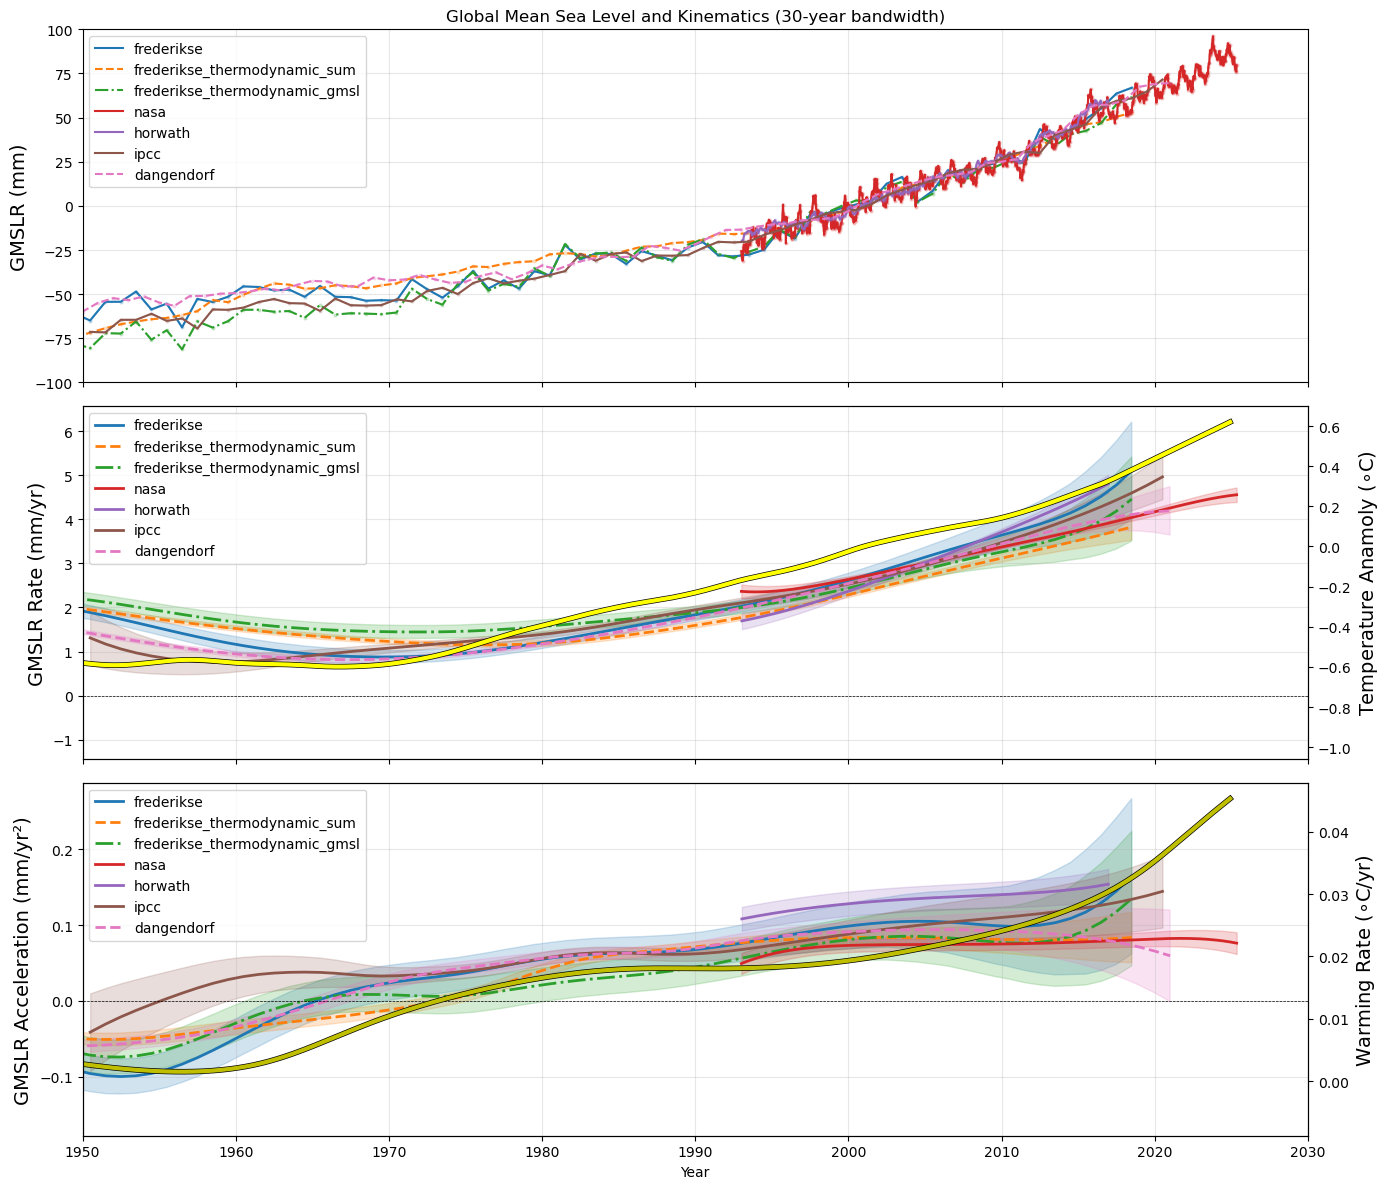

In [16]:
# -----------------------------------------------------------------------------
# PLOT: SLR Cummulative, Rates, and Accelerations
# -----------------------------------------------------------------------------

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
label_fontsize = 14

# Color scheme for datasets
colors = {
    'frederikse': 'C0',
    'frederikse_thermodynamic_sum' : 'C1',
    'frederikse_thermodynamic_gmsl' : 'C2',
    'nasa': 'C3', 
    'horwath': 'C4',
    'ipcc': 'C5',
    'dangendorf': 'C6'
}

linestyles = {
    'frederikse': '-',
    'frederikse_thermodynamic_sum' : '--',
    'frederikse_thermodynamic_gmsl' : '-.',
    'nasa': '-', 
    'horwath': '-',
    'ipcc': '-',
    'dangendorf': '--'
}

# ax1: GMSL data with fitted values
for name in kinematics_dfs:
    df = kinematics_dfs[name]
    valid = ~np.isnan(df['rate'])
    
    # Get original data
    if name == 'frederikse':
        orig_df = df_frederikse_h
        plot_type = 'gmsl'
    elif name == 'frederikse_thermodynamic_sum':
        orig_df = df_frederikse_thermo_h
        plot_type = 'thermodynamic_sum'
    elif name == 'frederikse_thermodynamic_gmsl':
        orig_df = df_frederikse_thermo_h
        plot_type = 'thermodynamic_gmsl'
    elif name == 'nasa':
        orig_df = df_nasa_gmsl_h
        plot_type = 'gmsl'
    elif name == 'horwath':
        orig_df = df_horwath_h
        plot_type = 'gmsl'
    elif name == 'ipcc':
        orig_df = df_ipcc_observed_gmsl_h
        plot_type = 'gmsl'
    elif name == 'dangendorf':
        orig_df = df_dangendorf_h
        plot_type = 'gmsl'

    # Plot original data (light)
    ax1.plot(df['decimal_year'], orig_df[plot_type].values * 1000, 
             'o', color=colors[name], ls=linestyles[name], alpha=0.2, markersize=2)
    # Plot would need fitted values - using smoothed rate integration as proxy
    ax1.plot(df.loc[valid, 'decimal_year'], orig_df.loc[valid.values, plot_type].values * 1000,
             color=colors[name], ls=linestyles[name], linewidth=1.5, label=name)

ax1.set_ylabel('GMSLR (mm)',fontsize=label_fontsize)
ax1.set_title(f'Global Mean Sea Level and Kinematics ({SPAN_YEARS}-year bandwidth)')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([1950,2030])
ax1.set_ylim([-100,100])

ax22 = ax2.twinx()
berkeley_lowess_smooth = sm.nonparametric.lowess(df_berkeley_h['temperature'],df_berkeley_h.index,frac=0.1)[:,1]
ax22.plot(get_decimal_year(df_berkeley_h), berkeley_lowess_smooth,'k',lw=4)
ax22.plot(get_decimal_year(df_berkeley_h), berkeley_lowess_smooth,'yellow',lw=3)
ax22.set_ylabel('Temperature Anamoly ($\\circ$C)',fontsize=label_fontsize)
    
# ax2: Rates
for name in kinematics_dfs:
    df = kinematics_dfs[name]
    valid = ~np.isnan(df['rate'])
    rate_mm = df['rate'] * 1000
    rate_se_mm = df['rate_se'] * 1000
    
    ax2.plot(df.loc[valid, 'decimal_year'], rate_mm[valid], 
             ls=linestyles[name], color=colors[name], linewidth=2, label=name)
    ax2.fill_between(df.loc[valid, 'decimal_year'], 
                     (rate_mm - 1.96*rate_se_mm)[valid],
                     (rate_mm + 1.96*rate_se_mm)[valid],
                     color=colors[name], alpha=0.2)

ax2.set_ylabel('GMSLR Rate (mm/yr)',fontsize=label_fontsize)
ax2.axhline(0, color='k', linestyle='--', linewidth=0.5)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.set_xlim([1950,2030])

# ax3: Accelerations
ax33 = ax3.twinx()
df = gmst_kinematics_dfs['berkeley']
valid = ~np.isnan(df['rate'])
gmst_rate = df['rate']

ax33.plot(df.loc[valid, 'decimal_year'],gmst_rate, ls='-',color='k',lw=4)
ax33.plot(df.loc[valid, 'decimal_year'],gmst_rate, ls='-',color='y',lw=3, label='Berkeley Earth GMST')
ax33.set_ylabel('Warming Rate ($\\circ$C/yr)',fontsize=label_fontsize)

for name in kinematics_dfs:
    df = kinematics_dfs[name]
    valid = ~np.isnan(df['accel'])
    accel_mm = df['accel'] * 1000
    accel_se_mm = df['accel_se'] * 1000
    
    ax3.plot(df.loc[valid, 'decimal_year'], accel_mm[valid],
             ls=linestyles[name], color=colors[name], linewidth=2, label=name)
    ax3.fill_between(df.loc[valid, 'decimal_year'],
                     (accel_mm - 1.96*accel_se_mm)[valid],
                     (accel_mm + 1.96*accel_se_mm)[valid],
                     color=colors[name], alpha=0.2)

ax3.set_ylabel('GMSLR Acceleration (mm/yr²)',fontsize=label_fontsize)
ax3.set_xlabel('Year')
ax3.axhline(0, color='k', linestyle='--', linewidth=0.5)
ax3.legend(loc='upper left')
ax3.grid(True, alpha=0.3)
ax3.set_xlim([1950,2030])

plt.tight_layout()
plt.savefig('figures/gmsl_kinematics.png', dpi=150, bbox_inches='tight')
plt.show()

### 6.3 Rate vs. Temperature Phase Plot



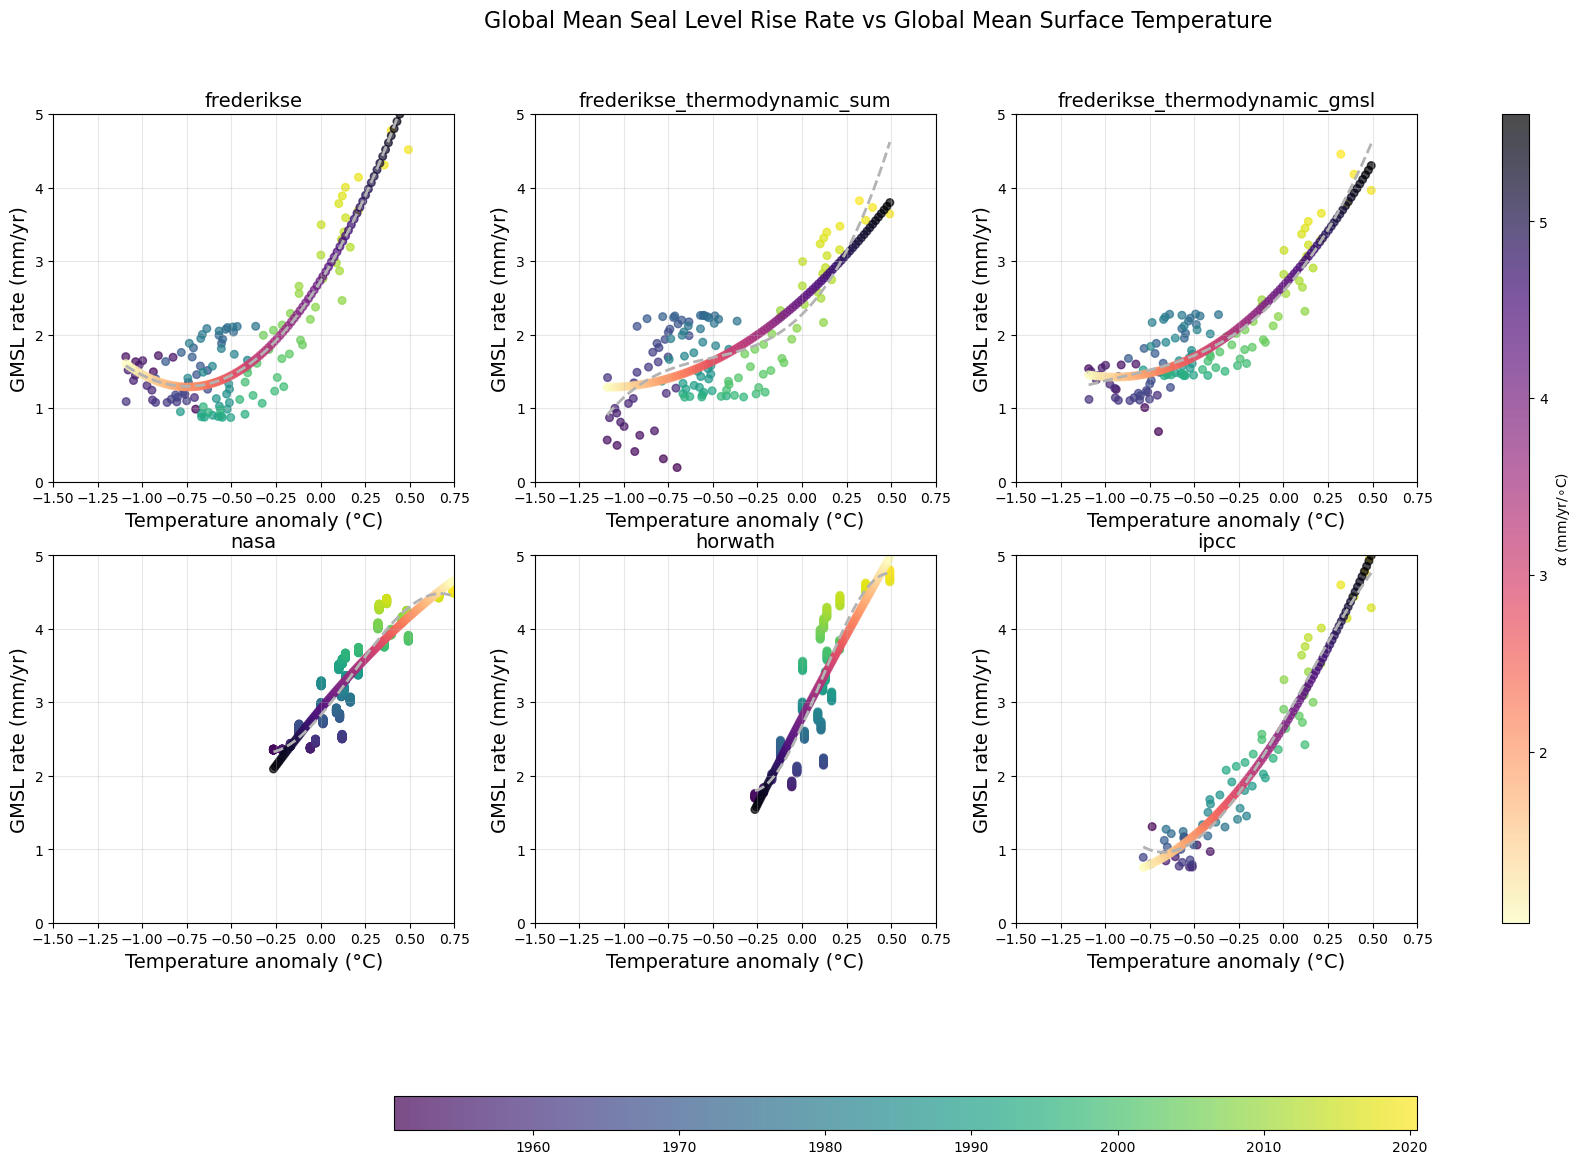

In [17]:
# -----------------------------------------------------------------------------
# PLOT: Rate vs Temperature phase plot
# -----------------------------------------------------------------------------

# Resample Berkeley Earth to annual for matching
df_berkeley_annual = df_berkeley_h.resample('YE').mean()
df_berkeley_annual['decimal_year'] = df_berkeley_annual.index.year + 0.5

fig, axes = plt.subplots(2, 3, figsize=(22, 15))
axes = axes.flatten()

label_fontsize = 14

for i, name in enumerate(kinematics_dfs):
    if i >= 6:
        break
    
    df_kin = kinematics_dfs[name]
    valid = ~np.isnan(df_kin['rate'])
    
    # Match time points with temperature
    kin_years = df_kin.loc[valid, 'decimal_year'].values
    rate_mm = df_kin.loc[valid, 'rate'].values * 1000
    
    # Find matching temperature values
    temp_matched = []
    rate_matched = []
    time_matched = []
    
    for year, rate in zip(kin_years, rate_mm):
        # Find closest temperature year
        temp_idx = np.argmin(np.abs(df_berkeley_annual['decimal_year'].values - year))
        if np.abs(df_berkeley_annual['decimal_year'].values[temp_idx] - year) < 1.0:
            temp_matched.append(df_berkeley_annual['temperature'].values[temp_idx])
            rate_matched.append(rate)
            time_matched.append(year)
    
    temp_matched = np.array(temp_matched)
    rate_matched = np.array(rate_matched)
    time_matched = np.array(time_matched)
    
    # Scatter plot colored by time
    sc = axes[i].scatter(temp_matched, rate_matched, c=time_matched, 
                         cmap='viridis', s=30, alpha=0.7)
    
    # Linear fit for α estimation
    if len(temp_matched) > 10:
        mask = ~(np.isnan(temp_matched) | np.isnan(rate_matched))
        if mask.sum() > 10:
            z = np.polyfit(temp_matched[mask], rate_matched[mask], 2)
            p = np.poly1d(z)
            temp_range = np.linspace(temp_matched[mask].min(), temp_matched[mask].max(), 100)
            #axes[i].plot(temp_range, p(temp_range), 'r--', linewidth=2, 
            #            label=f"{z[0]:.1f}$\\Delta T^2$ + {z[1]:.1f}$\\Delta T$...") #label=f'$\\alpha$ ≈ {z[1]:.1f} mm/yr/°C')
            sr = axes[i].scatter(temp_range, p(temp_range), c=np.gradient(p(temp_range),temp_range),
                            cmap='magma_r', s=30, alpha=0.7)
            z = np.polyfit(temp_matched[mask], rate_matched[mask], 3)
            p = np.poly1d(z)
            temp_range = np.linspace(temp_matched[mask].min(), temp_matched[mask].max(), 100)
            axes[i].plot(temp_range, p(temp_range), '--',color='0.7', linewidth=2) 
            #            label=f"{z[0]:.1f}$\\Delta T^3$ + {z[1]:.1f}$\\Delta T^2$ + {z[2]:.1f}$\\Delta T$...")

    axes[i].set_xlim([-1.5,0.75])
    axes[i].set_ylim([0,5])
    axes[i].set_xlabel('Temperature anomaly (°C)',fontsize=label_fontsize)
    axes[i].set_ylabel('GMSL rate (mm/yr)',fontsize=label_fontsize)
    axes[i].set_title(name,fontsize=label_fontsize)
    axes[i].grid(True, alpha=0.3)
    #axes[i].legend()

# Remove empty subplot if only 5 datasets
if len(kinematics) < 6:
    axes[-1].axis('off')
#print(plt.colorbar.__doc__)
plt.colorbar(sc, ax=axes, shrink=0.6, aspect=30, location='bottom', orientation='horizontal')
plt.colorbar(sr, ax=axes, shrink=1, aspect=30, label='$\\alpha$ (mm/yr/$\\circ$C)')
plt.suptitle('Global Mean Seal Level Rise Rate vs Global Mean Surface Temperature',fontsize=label_fontsize+2, y=0.95)
#plt.tight_layout()
plt.savefig('figures/rate_vs_temperature_phase.png', dpi=150, bbox_inches='tight')
plt.show()


---
## Data Summary

In [18]:
summary = pd.DataFrame({
    'Dataset': ['Frederikse', 'NASA Altimetry', 'Horwath/ESA', 'IMBIE WAIS', 'Berkeley', 'HadCRUT5', 'GISTEMP', 'NOAA'],
    'Type': ['GMSL', 'GMSL', 'GMSL', 'GMSL', 'Temp', 'Temp', 'Temp', 'Temp'],
    'Start': ['1900', '1993', '1993', '1992', '1850', '1850', '1880', '1850'],
    'End': ['2018', '2025', '2016', '2022','2024', '2025', '2025', '2025'],
    'Resolution': ['Annual', '10-day', 'Monthly', 'Monthly', 'Monthly', 'Monthly', 'Monthly', 'Annual'],
    'Has Uncertainty': [True, True, True, True, True, True, False, False]
})
print(summary.to_string(index=False))

       Dataset Type Start  End Resolution  Has Uncertainty
    Frederikse GMSL  1900 2018     Annual             True
NASA Altimetry GMSL  1993 2025     10-day             True
   Horwath/ESA GMSL  1993 2016    Monthly             True
    IMBIE WAIS GMSL  1992 2022    Monthly             True
      Berkeley Temp  1850 2024    Monthly             True
      HadCRUT5 Temp  1850 2025    Monthly             True
       GISTEMP Temp  1880 2025    Monthly            False
          NOAA Temp  1850 2025     Annual            False


---

## Fit dynamic sensitivity 


### 1. Statistical tests for quadratic vs linear fits 

In [19]:
#####
# Test robustness of quadratic and linear fits

from slr_analysis import test_rate_temperature_nonlinearity

# Get rate from kinematics
df_kin = kinematics_dfs['frederikse']
valid = ~np.isnan(df_kin['rate'])

rate = df_kin.loc[valid, 'rate'].values * 1000  # mm/yr
rate_se = df_kin.loc[valid, 'rate_se'].values * 1000

# Get corresponding temperatures (need to align by year)
years = df_kin.loc[valid, 'decimal_year'].values
temp = np.interp(years, get_decimal_year(df_berkeley_h), df_berkeley_h['temperature'])

# Run diagnostic
result = test_rate_temperature_nonlinearity(rate, temp, rate_sigma=rate_se)

# Print results
print('Frederikse')
print(result['recommendation'])
print(f"\nLinear:    rate = {result['linear']['coeffs'][0]:.2f}×T + {result['linear']['coeffs'][1]:.2f}")
print(f"Quadratic: rate = {result['quadratic']['coeffs'][0]:.2f}×T² + {result['quadratic']['coeffs'][1]:.2f}×T + {result['quadratic']['coeffs'][2]:.2f}")
print(f"\nF-test: F={result['f_test']['f_stat']:.2f}, p={result['f_test']['p_value']:.4f}")
print(f"R² linear: {result['linear']['r2']:.3f}, R² quadratic: {result['quadratic']['r2']:.3f}")

df_kin = kinematics_dfs['ipcc']
valid = ~np.isnan(df_kin['rate'])

rate = df_kin.loc[valid, 'rate'].values * 1000  # mm/yr
rate_se = df_kin.loc[valid, 'rate_se'].values * 1000

# Get corresponding temperatures (need to align by year)
years = df_kin.loc[valid, 'decimal_year'].values
temp = np.interp(years, get_decimal_year(df_berkeley_h), df_berkeley_h['temperature'])

# Run diagnostic
result = test_rate_temperature_nonlinearity(rate, temp, rate_sigma=rate_se)

print('\n\nIPCC')
print(result['recommendation'])
print(f"\nLinear:    rate = {result['linear']['coeffs'][0]:.2f}×T + {result['linear']['coeffs'][1]:.2f}")
print(f"Quadratic: rate = {result['quadratic']['coeffs'][0]:.2f}×T² + {result['quadratic']['coeffs'][1]:.2f}×T + {result['quadratic']['coeffs'][2]:.2f}")
print(f"\nF-test: F={result['f_test']['f_stat']:.2f}, p={result['f_test']['p_value']:.4f}")
print(f"R² linear: {result['linear']['r2']:.3f}, R² quadratic: {result['quadratic']['r2']:.3f}")

Frederikse
QUADRATIC model preferred. F-test significant (p=0.0001); AIC favors quadratic (ΔAIC=14.8); BIC favors quadratic (ΔBIC=12.0); R² improvement: 0.0777 (0.408 → 0.486)

Linear:    rate = 1.52×T + 2.35
Quadratic: rate = 2.10×T² + 3.25×T + 2.56

F-test: F=17.55, p=0.0001
R² linear: 0.408, R² quadratic: 0.486


IPCC
QUADRATIC model preferred. F-test significant (p=0.0015); AIC favors quadratic (ΔAIC=8.6); BIC favors quadratic (ΔBIC=6.3); R² improvement: 0.0357 (0.741 → 0.777)

Linear:    rate = 2.67×T + 2.72
Quadratic: rate = 2.35×T² + 3.99×T + 2.74

F-test: F=10.90, p=0.0015
R² linear: 0.741, R² quadratic: 0.777


### 3. Fit quadtraic alpha using DLS framework

In [20]:
# Calibrate quadratic model
from slr_analysis import calibrate_alpha_dols_quadratic

result = calibrate_alpha_dols_quadratic(
    sea_level=df_frederikse_h['gmsl'],
    temperature=df_berkeley_h['temperature'],
    n_lags=2
)

print(result)
# DOLSQuadraticResult(
#   α₀ = 3.25 ± 0.XX (linear sensitivity)
#   dα/dT = 2.10 ± 0.XX (quadratic sensitivity)
#   trend = 0.00XX ± 0.00XX
#   R² = 0.XXX, R²_adj = 0.XXX
#   ...
# )

# Predict rate at different temperatures
T_future = np.array([1.0, 1.5, 2.0, 3.0, 4.0])
rates = result.predict_rate(T_future)
rate_lo, rate_hi = result.predict_rate_ci(T_future)

for t, r, lo, hi in zip(T_future, rates, rate_lo, rate_hi):
    print(f"T={t:.1f}°C: rate = {1000*r:.1f} [{1000*lo:.1f}, {1000*hi:.1f}] mm/yr")

DOLSQuadraticResult(
  α₀ = 0.004 ± 0.001 (linear sensitivity)
  dα/dT = 0.006 ± 0.003 (quadratic sensitivity)
  trend = 0.0026 ± 0.0002
  R² = 0.969, R²_adj = 0.966
  AIC = -732.6, BIC = -707.9
  n_obs = 115, n_lags = 2
)
T=1.0°C: rate = 13.1 [5.0, 21.2] mm/yr
T=1.5°C: rate = 23.2 [7.1, 39.3] mm/yr
T=2.0°C: rate = 36.5 [9.6, 63.4] mm/yr
T=3.0°C: rate = 72.8 [16.3, 129.4] mm/yr
T=4.0°C: rate = 122.0 [24.9, 219.2] mm/yr


---
## 7. Sea Level Projections to 2100

Project GMSL to 2100 using the calibrated quadratic rate–temperature relationship from the DOLS fit above, driven by IPCC AR6 temperature projections for SSP1-2.6, SSP2-4.5, and SSP5-8.5.

**Model:** $\frac{d(\text{GMSL})}{dt} = \frac{d\alpha}{dT} T^2 + \alpha_0 T + c$

**Uncertainty:** 90% confidence interval (5th–95th percentile) from 1000-member Monte Carlo ensemble sampling the coefficient covariance matrix, propagated through IPCC temperature uncertainty.

**Reference points:** IPCC AR6 WG1 Chapter 9 projected GMSL (Fox-Kemper et al., 2021).

Temperature offset (1850-1900 → 1995-2005): 0.726 °C


DOLS coefficients [dα/dT, α₀, trend] (mm/yr): [6.45, 4.05, 2.58]


Trend extrapolation (1993-2020 quadratic):
  accel = 0.111 mm/yr², rate@2005 = 2.93 mm/yr
  At 2100: 788 [647, 929] mm


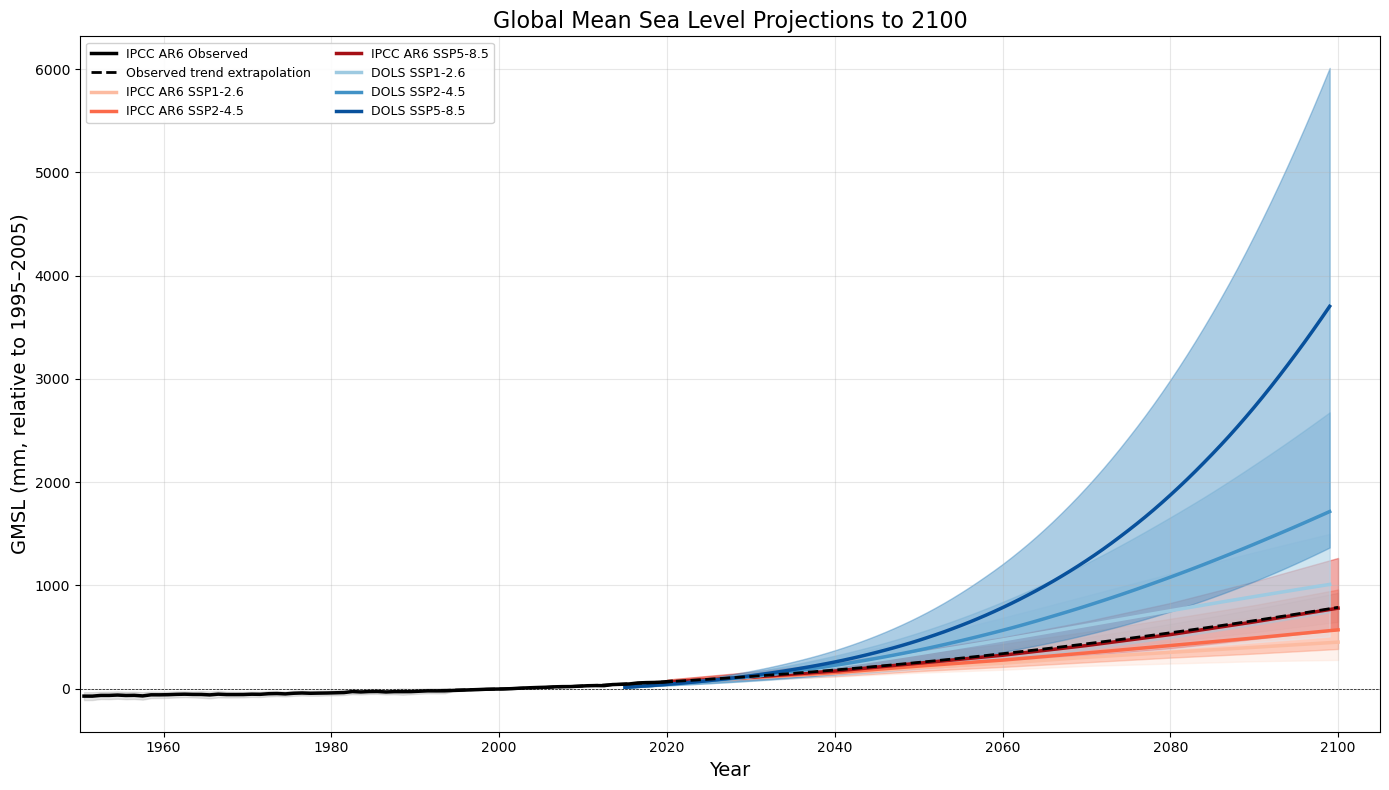


Scenario         IPCC AR6 2100 (mm)           DOLS model 2100 (mm)        
SSP1-2.6           451 [  279,   789]        1010 [  506,  1499]
SSP2-4.5           570 [  385,   960]        1716 [  740,  2676]
SSP5-8.5           780 [  569,  1266]        3703 [ 1367,  6011]
Trend extrap.      788 [  647,   929]


In [21]:
# [PROJ-PLOT] -----------------------------------------------------------------
# Sea Level Projections to 2100 with 90% CI
# -----------------------------------------------------------------------------

# temp_projections and ipcc_gmsl_proj already loaded from HDF5
from slr_projections import project_gmsl_ensemble

# =============================================================================
# 1. Load IPCC AR6 temperature projections and re-baseline
# =============================================================================
# temp_projections loaded from h5 (1850-1900 baseline)

# Re-baseline temperatures from 1850-1900 to 1995-2005
df_hist_temp = temp_projections['Historical']
baseline_offset = df_hist_temp.loc[
    (df_hist_temp['decimal_year'] >= 1995) & (df_hist_temp['decimal_year'] <= 2005),
    'temperature'
].mean()
print(f"Temperature offset (1850-1900 → 1995-2005): {baseline_offset:.3f} °C")

ssp_scenarios = {}
for scenario in ['SSP1_2_6', 'SSP2_4_5', 'SSP5_8_5']:
    df_ssp = temp_projections[scenario].copy()
    df_ssp['temperature'] -= baseline_offset
    df_ssp['temperature_lower'] -= baseline_offset
    df_ssp['temperature_upper'] -= baseline_offset
    ssp_scenarios[scenario] = df_ssp

# =============================================================================
# 2. DOLS model-based projections (blue family)
# =============================================================================
# DOLS coefficients are in meters; convert to mm for projection
coeffs_m = np.array([result.dalpha_dT, result.alpha0, result.trend])  # m/yr
coeffs_mm = coeffs_m * 1000  # mm/yr

# Transform covariance from DOLS parameterization (coeff[0]=dalpha_dT/2)
# and convert from m to mm (multiply by 1000²)
cov_full = result.covariance
cov_3x3_m = np.zeros((3, 3))
cov_3x3_m[0, 0] = 4 * cov_full[0, 0]
cov_3x3_m[0, 1] = 2 * cov_full[0, 1]
cov_3x3_m[0, 2] = 2 * cov_full[0, 2]
cov_3x3_m[1, 0] = cov_3x3_m[0, 1]
cov_3x3_m[1, 1] = cov_full[1, 1]
cov_3x3_m[1, 2] = cov_full[1, 2]
cov_3x3_m[2, 0] = cov_3x3_m[0, 2]
cov_3x3_m[2, 1] = cov_3x3_m[1, 2]
cov_3x3_m[2, 2] = cov_full[2, 2]
cov_3x3_mm = cov_3x3_m * (1000**2)  # m² → mm²

# Baseline GMSL at 2005 in mm (1995-2005 baseline)
baseline_year = 2005.0
baseline_gmsl_mm = df_ipcc_observed_gmsl_h.loc['2005', 'gmsl'].values[0] * 1000

proj_results = project_gmsl_ensemble(
    coefficients=coeffs_mm,
    coefficients_cov=cov_3x3_mm,
    temperature_projections=ssp_scenarios,
    baseline_year=baseline_year,
    baseline_gmsl=baseline_gmsl_mm,
    n_samples=1000,
    seed=42,
)
print(f"DOLS coefficients [dα/dT, α₀, trend] (mm/yr): [{coeffs_mm[0]:.2f}, {coeffs_mm[1]:.2f}, {coeffs_mm[2]:.2f}]")

# =============================================================================
# 3. IPCC AR6 FACTS projections (red family)
# =============================================================================
# ipcc_gmsl_proj already loaded from h5

# FACTS projections are relative to 2005; shift to 1995-2005 baseline
ipcc_baseline_shift = baseline_gmsl_mm  # observed GMSL at 2005 in our baseline (mm)

# =============================================================================
# 4. Observed trend extrapolation (dashed black)
# =============================================================================
# Use IPCC observed GMSL: fit quadratic (constant acceleration) over 1993-2020
obs_years = get_decimal_year(df_ipcc_observed_gmsl_h)
obs_gmsl_mm = df_ipcc_observed_gmsl_h['gmsl'].values * 1000
obs_sigma_mm = df_ipcc_observed_gmsl_h['gmsl_sigma'].values * 1000

# Fit over satellite era (1993-2020) for the most recent trend
sat_mask = obs_years >= 1993
t_sat = obs_years[sat_mask]
y_sat = obs_gmsl_mm[sat_mask]
s_sat = obs_sigma_mm[sat_mask]

# Weighted quadratic fit: GMSL = a*(t-t0)^2 + b*(t-t0) + c
t0_extrap = 2005.0
dt_sat = t_sat - t0_extrap
weights = 1.0 / s_sat**2
# Build weighted design matrix
A = np.column_stack([dt_sat**2, dt_sat, np.ones_like(dt_sat)])
W = np.diag(weights)
AtWA = A.T @ W @ A
AtWy = A.T @ W @ y_sat
p_extrap = np.linalg.solve(AtWA, AtWy)  # [a, b, c]
cov_extrap = np.linalg.inv(AtWA)  # covariance of [a, b, c]

# Extrapolate to 2100
t_future = np.arange(1993, 2101, 1.0)
dt_future = t_future - t0_extrap
A_future = np.column_stack([dt_future**2, dt_future, np.ones_like(dt_future)])
extrap_gmsl = A_future @ p_extrap

# 90% CI via prediction variance: var(y) = A @ cov @ A.T diagonal
extrap_var = np.sum((A_future @ cov_extrap) * A_future, axis=1)
z90 = 1.645
extrap_lower = extrap_gmsl - z90 * np.sqrt(extrap_var)
extrap_upper = extrap_gmsl + z90 * np.sqrt(extrap_var)

print(f"Trend extrapolation (1993-2020 quadratic):")
print(f"  accel = {2*p_extrap[0]:.3f} mm/yr², rate@2005 = {p_extrap[1]:.2f} mm/yr")
print(f"  At 2100: {extrap_gmsl[-1]:.0f} [{extrap_lower[-1]:.0f}, {extrap_upper[-1]:.0f}] mm")

# =============================================================================
# 5. Plot
# =============================================================================
fig, ax = plt.subplots(figsize=(14, 8))
label_fontsize = 14

# --- Observed GMSL ---
ax.plot(obs_years, obs_gmsl_mm, 'k-', lw=2.5, label='IPCC AR6 Observed', zorder=10)
ax.fill_between(obs_years,
                (obs_gmsl_mm - 1.645 * obs_sigma_mm),
                (obs_gmsl_mm + 1.645 * obs_sigma_mm),
                color='k', alpha=0.1)

# --- Trend extrapolation (dashed black) ---
ax.plot(t_future, extrap_gmsl, 'k--', lw=2, label='Observed trend extrapolation', zorder=9)
ax.fill_between(t_future, extrap_lower, extrap_upper, color='k', alpha=0.08)

# --- IPCC FACTS projections (red family) ---
ipcc_red_colors = {
    'ssp126': '#fee0d2',  # lightest
    'ssp245': '#fc9272',
    'ssp585': '#de2d26',  # darkest
}
ipcc_labels = {
    'ssp126': 'IPCC AR6 SSP1-2.6',
    'ssp245': 'IPCC AR6 SSP2-4.5',
    'ssp585': 'IPCC AR6 SSP5-8.5',
}
ipcc_line_colors = {
    'ssp126': '#fcbba1',
    'ssp245': '#fb6a4a',
    'ssp585': '#a50f15',
}

for ssp in ['ssp126', 'ssp245', 'ssp585']:
    df_ip = ipcc_gmsl_proj[ssp]
    ip_years = df_ip['decimal_year'].values
    ip_gmsl = df_ip['gmsl'].values * 1000 + ipcc_baseline_shift  # mm, shifted
    ip_lower = df_ip['gmsl_lower'].values * 1000 + ipcc_baseline_shift
    ip_upper = df_ip['gmsl_upper'].values * 1000 + ipcc_baseline_shift

    # Only plot up to 2100
    mask_2100 = ip_years <= 2100
    ax.plot(ip_years[mask_2100], ip_gmsl[mask_2100], '-', color=ipcc_line_colors[ssp],
            lw=2.5, label=ipcc_labels[ssp])
    ax.fill_between(ip_years[mask_2100], ip_lower[mask_2100], ip_upper[mask_2100],
                    color=ipcc_red_colors[ssp], alpha=0.4)

# --- DOLS model projections (blue family) ---
dols_blue_colors = {
    'SSP1_2_6': '#deebf7',  # lightest
    'SSP2_4_5': '#9ecae1',
    'SSP5_8_5': '#3182bd',  # darkest
}
dols_line_colors = {
    'SSP1_2_6': '#9ecae1',
    'SSP2_4_5': '#4292c6',
    'SSP5_8_5': '#08519c',
}
dols_labels = {
    'SSP1_2_6': 'DOLS SSP1-2.6',
    'SSP2_4_5': 'DOLS SSP2-4.5',
    'SSP5_8_5': 'DOLS SSP5-8.5',
}

for scenario in ['SSP1_2_6', 'SSP2_4_5', 'SSP5_8_5']:
    df_proj = proj_results['scenarios'][scenario]
    years = df_proj['decimal_year'].values
    mask_2100 = years <= 2100

    ax.plot(years[mask_2100], df_proj['gmsl'].values[mask_2100], '-',
            color=dols_line_colors[scenario], lw=2.5, label=dols_labels[scenario])
    ax.fill_between(years[mask_2100],
                    df_proj['gmsl_lower'].values[mask_2100],
                    df_proj['gmsl_upper'].values[mask_2100],
                    color=dols_blue_colors[scenario], alpha=0.4)

# --- Axis formatting ---
ax.axhline(0, color='k', lw=0.5, ls='--')
ax.set_xlabel('Year', fontsize=label_fontsize)
ax.set_ylabel('GMSL (mm, relative to 1995–2005)', fontsize=label_fontsize)
ax.set_title('Global Mean Sea Level Projections to 2100', fontsize=label_fontsize + 2)
ax.set_xlim([1950, 2105])
ax.legend(loc='upper left', fontsize=9, ncol=2, framealpha=0.9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/gmsl_projections_2100.png', dpi=150, bbox_inches='tight')
plt.show()

# =============================================================================
# Summary table
# =============================================================================
print(f"\n{'':=<80}")
print(f"{'Scenario':<16} {'IPCC AR6 2100 (mm)':<28} {'DOLS model 2100 (mm)':<28}")
print(f"{'':=<80}")
for ssp, scenario in [('ssp126', 'SSP1_2_6'), ('ssp245', 'SSP2_4_5'), ('ssp585', 'SSP5_8_5')]:
    ssp_label = {'ssp126': 'SSP1-2.6', 'ssp245': 'SSP2-4.5', 'ssp585': 'SSP5-8.5'}[ssp]
    # IPCC
    df_ip = ipcc_gmsl_proj[ssp]
    row = df_ip[df_ip['decimal_year'] == 2100].iloc[0]
    ip = row['gmsl'] * 1000 + ipcc_baseline_shift
    ip_lo = row['gmsl_lower'] * 1000 + ipcc_baseline_shift
    ip_hi = row['gmsl_upper'] * 1000 + ipcc_baseline_shift
    # DOLS
    df_d = proj_results['scenarios'][scenario]
    idx = np.argmin(np.abs(df_d['decimal_year'].values - 2100))
    d = df_d['gmsl'].iloc[idx]
    d_lo = df_d['gmsl_lower'].iloc[idx]
    d_hi = df_d['gmsl_upper'].iloc[idx]
    print(f"{ssp_label:<16} {ip:>5.0f} [{ip_lo:>5.0f}, {ip_hi:>5.0f}]       {d:>5.0f} [{d_lo:>5.0f}, {d_hi:>5.0f}]")

print(f"{'Trend extrap.':<16} {extrap_gmsl[-1]:>5.0f} [{extrap_lower[-1]:>5.0f}, {extrap_upper[-1]:>5.0f}]")
print(f"{'':=<80}")

2050 SSP1-2.6: IPCC ~ N(217, 47) [141, 294] mm (90% CI)  |  DOLS = 344 [188, 501] mm
2050 SSP2-4.5: IPCC ~ N(233, 47) [155, 310] mm (90% CI)  |  DOLS = 380 [200, 559] mm
2050 Trend: 255 [226, 284] mm

2075 SSP1-2.6: IPCC ~ N(354, 93) [201, 507] mm (90% CI)  |  DOLS = 695 [351, 1036] mm
2075 SSP2-4.5: IPCC ~ N(408, 100) [244, 572] mm (90% CI)  |  DOLS = 953 [437, 1463] mm
2075 Trend: 487 [414, 562] mm

2100 SSP1-2.6: IPCC ~ N(484, 152) [234, 734] mm (90% CI)  |  DOLS = 1026 [506, 1541] mm
2100 SSP2-4.5: IPCC ~ N(613, 171) [333, 894] mm (90% CI)  |  DOLS = 1748 [739, 2739] mm
2100 Trend: 787 [651, 931] mm



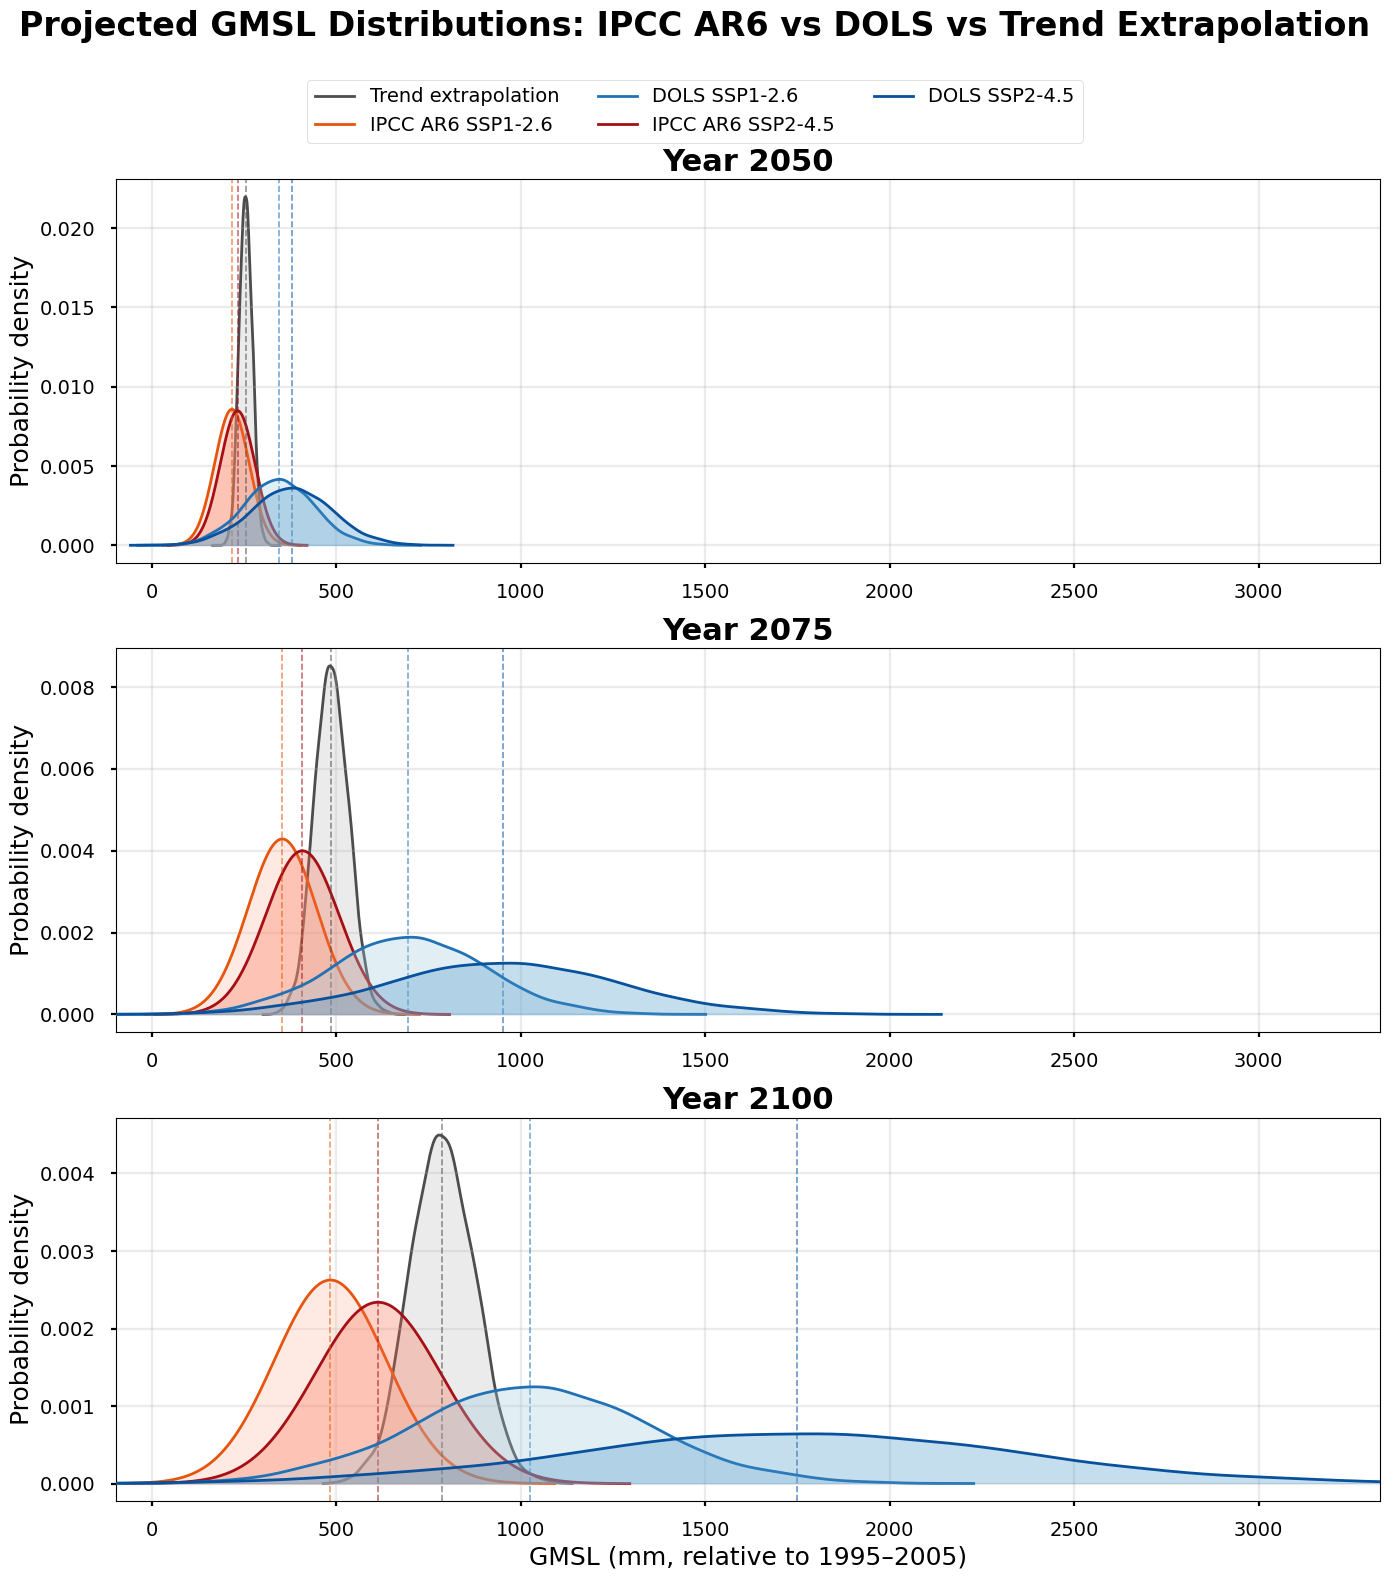

In [24]:
# [PROJ-HIST] -------------------------------------------------------------------
# Histograms of projected GMSL at user-defined years
# Compares IPCC AR6 FACTS (red), DOLS model (blue), trend extrapolation (grey)
# for SSP1-2.6 and SSP2-4.5 scenarios
# ------------------------------------------------------------------------------
#
# TODO: The IPCC FACTS medium-confidence quantile files contain a p-box artefact
#       (discrete jump at the median from combining pb_1e and pb_1f expert-
#       judgment distributions).  Here we approximate each scenario/year as a
#       Gaussian fitted to the 17th–83rd percentile range.  This is adequate for
#       visualization but discards the heavy upper tail.
#
#       For a proper treatment, search the FACTS processing scripts in:
#           BASE_DIR/data/raw/ipcc_ar6/slr/ar6/scripts/
#       Key files to examine:
#           - convert_samples_to_dist.py    (samples → quantile distributions)
#           - generate_pbox_components.py   (p-box combination logic)
#           - generate_confidence_output_files.py (confidence-level aggregation)
#           - sample_from_quantiles.py      (quantile → sample inversion)
#       These may provide access to the underlying Monte Carlo samples before
#       the p-box merge, which would give smooth per-component PDFs that can
#       be combined without the median discontinuity.
# ------------------------------------------------------------------------------
import xarray as xr
from scipy.stats import norm, gaussian_kde

target_years = [2050, 2075, 2100]

# =============================================================================
# 1. Build IPCC AR6 FACTS Gaussian approximations at target years
#
#    The raw quantile function has a discrete jump at q = 0.50 from the p-box
#    combination (lower half from pb_1e, upper half from pb_1f).  Rather than
#    attempting a splice, we fit a Gaussian using robust quantile-based
#    estimators that are unaffected by the median artefact:
#
#        mu    = midpoint of the 17th–83rd percentile ("likely") range
#        sigma = (q83 – q17) / (2 × 0.9674)       [z_{0.833} ≈ 0.9674]
#
#    This preserves the IPCC "likely" range exactly and gives a symmetric
#    PDF that is a reasonable approximation for the bulk of the distribution.
# =============================================================================
ipcc_facts_dir = DATA_IPCC_DIR / 'slr' / 'ar6' / 'global' / 'confidence_output_files' / 'medium_confidence'

Z_83 = 0.9674   # normal z-score at q = 0.833

ipcc_gauss_params = {}       # dict[ssp][yr] → (mu, sigma) in mm
ipcc_quantile_axes = {}      # dict[ssp] → raw quantile axis
ipcc_raw_quantile_vals = {}  # dict[ssp][yr] → raw 107-point quantile values (mm)

for ssp in ['ssp126', 'ssp245']:
    total_nc = ipcc_facts_dir / ssp / f'total_{ssp}_medium_confidence_values.nc'
    ds = xr.open_dataset(total_nc)
    sl = ds['sea_level_change'].values[:, :, 0]  # (quantiles, years), mm
    quantiles = ds['quantiles'].values
    years_nc = ds['years'].values
    ds.close()

    ipcc_quantile_axes[ssp] = quantiles
    ipcc_gauss_params[ssp] = {}
    ipcc_raw_quantile_vals[ssp] = {}

    i_q17 = np.argmin(np.abs(quantiles - 0.167))
    i_q83 = np.argmin(np.abs(quantiles - 0.833))

    for yr in target_years:
        # Interpolate between decadal time steps if needed (e.g. 2075)
        yr_lo_idx = np.searchsorted(years_nc, yr, side='right') - 1
        yr_lo_idx = max(0, min(yr_lo_idx, len(years_nc) - 2))
        yr_lo, yr_hi = years_nc[yr_lo_idx], years_nc[yr_lo_idx + 1]

        if yr_lo == yr:
            vals_mm = sl[:, yr_lo_idx].copy()
        else:
            frac = (yr - yr_lo) / (yr_hi - yr_lo)
            vals_mm = (sl[:, yr_lo_idx] * (1 - frac)
                       + sl[:, yr_lo_idx + 1] * frac)

        # Shift from 2005-relative to 1995-2005 baseline
        vals_mm = vals_mm + ipcc_baseline_shift
        ipcc_raw_quantile_vals[ssp][yr] = vals_mm.copy()

        # Fit Gaussian from 17th–83rd percentile range
        v17 = vals_mm[i_q17]
        v83 = vals_mm[i_q83]
        sigma = (v83 - v17) / (2 * Z_83)
        mu = 0.5 * (v17 + v83)
        ipcc_gauss_params[ssp][yr] = (mu, sigma)

# =============================================================================
# 2. Build DOLS model full ensemble distributions at target years
# =============================================================================
np.random.seed(42)
n_mc = 5000
coeff_draws = np.random.multivariate_normal(coeffs_mm, cov_3x3_mm, n_mc)

dols_ensemble_samples = {}
for scenario, ssp_label in [('SSP1_2_6', 'SSP1-2.6'), ('SSP2_4_5', 'SSP2-4.5')]:
    temp_df = ssp_scenarios[scenario]
    T = temp_df['temperature'].values
    time_yrs = temp_df['decimal_year'].values
    dt_arr = np.diff(time_yrs)
    b_idx = np.argmin(np.abs(time_yrs - baseline_year))

    gmsl_ens = np.zeros((n_mc, len(T)))
    for k, (a_k, b_k, c_k) in enumerate(coeff_draws):
        rate_k = a_k * T**2 + b_k * T + c_k
        g = np.zeros(len(T))
        g[b_idx] = baseline_gmsl_mm
        for i in range(b_idx, len(T) - 1):
            g[i + 1] = g[i] + 0.5 * (rate_k[i] + rate_k[i + 1]) * dt_arr[i]
        for i in range(b_idx, 0, -1):
            g[i - 1] = g[i] - 0.5 * (rate_k[i] + rate_k[i - 1]) * dt_arr[i - 1]
        gmsl_ens[k] = g

    dols_ensemble_samples[scenario] = {}
    for yr in target_years:
        yr_idx = np.argmin(np.abs(time_yrs - yr))
        dols_ensemble_samples[scenario][yr] = gmsl_ens[:, yr_idx]

# =============================================================================
# 3. Build trend extrapolation ensemble at target years
# =============================================================================
n_trend = 5000
np.random.seed(123)
p_draws = np.random.multivariate_normal(p_extrap, cov_extrap, n_trend)

trend_ensemble_samples = {}
for yr in target_years:
    dt_yr = yr - t0_extrap
    A_yr = np.array([dt_yr**2, dt_yr, 1.0])
    trend_ensemble_samples[yr] = p_draws @ A_yr  # mm

# =============================================================================
# 4. Plot — vertically stacked smooth KDE / Gaussian distributions
# =============================================================================
with plt.style.context('seaborn-v0_8-poster'):

    TITLE_FS = 22
    LABEL_FS = 18
    TICK_FS = 14
    LEGEND_FS = 14
    ANNOT_FS = 12

    ssp_pairs = [
        ('ssp126', 'SSP1_2_6', 'SSP1-2.6'),
        ('ssp245', 'SSP2_4_5', 'SSP2-4.5'),
    ]

    # Color assignments matching cell 45 [PROJ-PLOT]
    ipcc_fill_colors = {'ssp126': '#fcbba1', 'ssp245': '#fb6a4a'}
    ipcc_line_colors = {'ssp126': '#e6550d', 'ssp245': '#a50f15'}
    dols_fill_colors = {'SSP1_2_6': '#9ecae1', 'SSP2_4_5': '#4292c6'}
    dols_line_colors = {'SSP1_2_6': '#2171b5', 'SSP2_4_5': '#08519c'}
    trend_fill_color = '0.75'
    trend_line_color = '0.30'

    fig, axes = plt.subplots(len(target_years), 1,
                             figsize=(14, 5 * len(target_years)),
                             sharex=False)

    # Global x-range across all panels
    all_bounds = []
    for yr in target_years:
        all_bounds.extend(np.percentile(trend_ensemble_samples[yr], [0.5, 99.5]))
        for ssp, dk, _ in ssp_pairs:
            mu, sig = ipcc_gauss_params[ssp][yr]
            all_bounds.extend([mu - 3.5 * sig, mu + 3.5 * sig])
            all_bounds.extend(np.percentile(dols_ensemble_samples[dk][yr], [0.5, 99.5]))
    x_lo = min(all_bounds)
    x_hi = max(all_bounds)

    for row, (ax, yr) in enumerate(zip(axes, target_years)):

        # --- Trend extrapolation: smooth KDE ---
        trend_vals = trend_ensemble_samples[yr]
        kde_trend = gaussian_kde(trend_vals, bw_method='silverman')
        x_trend = np.linspace(trend_vals.min() - 30, trend_vals.max() + 30, 500)
        pdf_trend = kde_trend(x_trend)
        ax.fill_between(x_trend, pdf_trend, alpha=0.30, color=trend_fill_color,
                        zorder=1)
        ax.plot(x_trend, pdf_trend, color=trend_line_color, lw=2.0,
                label='Trend extrapolation', zorder=1)

        for ssp, dols_key, label in ssp_pairs:

            # --- IPCC FACTS: Gaussian approximation ---
            mu, sigma = ipcc_gauss_params[ssp][yr]
            x_gauss = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 500)
            pdf_gauss = norm.pdf(x_gauss, loc=mu, scale=sigma)

            ax.fill_between(x_gauss, pdf_gauss, alpha=0.30,
                            color=ipcc_fill_colors[ssp], zorder=2)
            ax.plot(x_gauss, pdf_gauss, color=ipcc_line_colors[ssp], lw=2.0,
                    label=f'IPCC AR6 {label}', zorder=2)

            # --- DOLS ensemble: KDE ---
            dols_vals = dols_ensemble_samples[dols_key][yr]
            kde_dols = gaussian_kde(dols_vals, bw_method='silverman')
            x_kde_d = np.linspace(dols_vals.min() - 30,
                                  dols_vals.max() + 30, 500)
            pdf_dols = kde_dols(x_kde_d)

            ax.fill_between(x_kde_d, pdf_dols, alpha=0.30,
                            color=dols_fill_colors[dols_key], zorder=3)
            ax.plot(x_kde_d, pdf_dols, color=dols_line_colors[dols_key], lw=2.0,
                    label=f'DOLS {label}', zorder=3)

        # --- Median dashed lines ---
        for ssp, dols_key, label in ssp_pairs:
            mu, _ = ipcc_gauss_params[ssp][yr]
            ax.axvline(mu, color=ipcc_line_colors[ssp],
                       ls='--', lw=1.2, alpha=0.6)

            d_vals = dols_ensemble_samples[dols_key][yr]
            ax.axvline(np.median(d_vals), color=dols_line_colors[dols_key],
                       ls='--', lw=1.2, alpha=0.6)

        ax.axvline(np.median(trend_vals), color=trend_line_color,
                   ls='--', lw=1.2, alpha=0.6)

        # --- Formatting ---
        ax.set_xlim([max(x_lo - 50, -100), x_hi + 50])
        ax.set_ylabel('Probability density', fontsize=LABEL_FS)
        ax.set_title(f'Year {yr}', fontsize=TITLE_FS, fontweight='bold')
        ax.tick_params(axis='both', labelsize=TICK_FS)
        ax.grid(True, alpha=0.25)

        if row == len(target_years) - 1:
            ax.set_xlabel('GMSL (mm, relative to 1995–2005)', fontsize=LABEL_FS)
        else:
            ax.set_xlabel('', fontsize=LABEL_FS)

        # --- Summary statistics ---
        for ssp, dols_key, label in ssp_pairs:
            mu, sigma = ipcc_gauss_params[ssp][yr]
            lo90 = mu - 1.645 * sigma
            hi90 = mu + 1.645 * sigma
            d_vals = dols_ensemble_samples[dols_key][yr]
            print(f"{yr} {label}: "
                  f"IPCC ~ N({mu:.0f}, {sigma:.0f}) "
                  f"[{lo90:.0f}, {hi90:.0f}] mm (90% CI)  |  "
                  f"DOLS = {np.median(d_vals):.0f} "
                  f"[{np.percentile(d_vals, 5):.0f}, "
                  f"{np.percentile(d_vals, 95):.0f}] mm")
        t_med = np.median(trend_vals)
        t_lo, t_hi = np.percentile(trend_vals, [5, 95])
        print(f"{yr} Trend: {t_med:.0f} [{t_lo:.0f}, {t_hi:.0f}] mm\n")

    # --- Shared legend ---
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=3,
               fontsize=LEGEND_FS, bbox_to_anchor=(0.5, 1.01),
               framealpha=0.9)

    fig.suptitle(
        'Projected GMSL Distributions: IPCC AR6 vs DOLS vs Trend Extrapolation',
        fontsize=TITLE_FS + 2, y=1.05, fontweight='bold')
    plt.tight_layout()
    plt.savefig('figures/gmsl_projection_histograms_thermoOnly.png', dpi=150,
                bbox_inches='tight')
    plt.show()

---
## 8. West Antarctic Ice Sheet (WAIS) Contribution Analysis

The DOLS model captures temperature-driven sea level processes (thermosteric expansion, glaciers, Greenland surface mass balance). However, **West Antarctic mass loss** is driven primarily by:

1. **Warm Circumpolar Deep Water (CDW)** intrusion beneath ice shelves
2. **Marine Ice Sheet Instability (MISI)** — positive feedback where grounding-line retreat on a retrograde bed accelerates discharge
3. **Ice-shelf collapse and calving** — structural failure not directly tied to surface temperature

Since these processes are largely independent of global mean surface temperature, the DOLS temperature-rate relationship does not capture WAIS contributions. Below we:

1. **Test for structural breaks** in the IMBIE WAIS mass balance record (1992-2020)
2. **Interpret the post-2010 deceleration** as ocean-variability noise on a committed signal
3. **Project WAIS contributions** using an acceleration-based extrapolation with three physically motivated scenarios
4. **Show combined DOLS + WAIS projections** alongside IPCC AR6 for comparison

### Why not use IPCC AR6 AIS projections as the primary WAIS estimate?

The IPCC AR6 FACTS AIS projections carry a **known low-end bias**:
- Process-based ice sheet models do not resolve calving dynamics, ice-cliff instability, or damage mechanics
- Sub-ice-shelf melt rates from coarse ocean models underestimate observed warm water intrusion at grounding lines
- The committed, potentially irreversible retreat of Thwaites Glacier is poorly represented
- The p-box construction (combining pb_1e and pb_1f) compresses the upper tail

We therefore use a **data-driven acceleration extrapolation** as the primary WAIS estimate, and show IPCC AR6 AIS for comparison only.

In [ ]:
# [WAIS-ANALYSIS] -------------------------------------------------------------
# West Antarctic Ice Sheet: Structural Break Detection, Acceleration-Based
# Projection, and Combined DOLS + WAIS Estimates
#
# Strategy: WAIS mass loss is independent of surface temperature and must be
# added as a separate component. We use the observed 1992-2020 acceleration
# as the basis for projection, with three scenarios spanning the plausible
# range of sustained acceleration. IPCC AR6 AIS is shown for comparison only
# (known low-end bias from process-model structural deficiencies).
#
# See: wais_massloss_strategy.tex for full rationale.
# -----------------------------------------------------------------------------
import xarray as xr
from scipy.stats import norm, gaussian_kde
from scipy import stats as sp_stats

# =============================================================================
# 1. IMBIE WAIS Time Series — Rate and Cumulative Mass Balance
# =============================================================================
wais_rate = df_imbie_wais['mass_balance_rate'].values * 1000       # m/yr -> mm/yr
wais_rate_sigma = df_imbie_wais['mass_balance_rate_sigma'].values * 1000
wais_cum = df_imbie_wais['cumulative_mass_balance'].values * 1000  # m -> mm
wais_cum_sigma = df_imbie_wais['cumulative_mass_balance_sigma'].values * 1000
wais_t = df_imbie_wais['decimal_year'].values

# Resample to annual for breakpoint tests (reduces autocorrelation)
df_wais_annual = df_imbie_wais.resample('YE').mean()
wais_yr = np.array([t.year + 0.5 for t in df_wais_annual.index])
wais_rate_yr = df_wais_annual['mass_balance_rate'].values * 1000
wais_rate_sigma_yr = df_wais_annual['mass_balance_rate_sigma'].values * 1000
wais_cum_yr = df_wais_annual['cumulative_mass_balance'].values * 1000
wais_cum_sigma_yr = df_wais_annual['cumulative_mass_balance_sigma'].values * 1000

print('=' * 80)
print('IMBIE WAIS Mass Balance Summary (1992-2020)')
print('=' * 80)
print(f'Period: {wais_t[0]:.1f} - {wais_t[-1]:.1f}  ({len(wais_t)} monthly records)')
print(f'Mean rate:  {wais_rate.mean():.3f} mm/yr  (SLE)')
print(f'Total cumulative loss: {wais_cum[-1]:.1f} mm SLE')

# =============================================================================
# 2. Structural Break Test (Chow test on annual rate series)
#
#    Piecewise linear regression on the rate time series:
#        rate(t) = a1 + b1*t   for t < t_break
#        rate(t) = a2 + b2*t   for t >= t_break
#    Search over candidate breakpoints; compare to single linear via F-test.
# =============================================================================
candidate_breaks = np.arange(1998, 2016, 0.5)
n_yr = len(wais_yr)

# Null model: single linear trend
X_global = np.column_stack([np.ones(n_yr), wais_yr - wais_yr.mean()])
beta_global = np.linalg.lstsq(X_global, wais_rate_yr, rcond=None)[0]
rss_global = np.sum((wais_rate_yr - X_global @ beta_global) ** 2)

# Grid search for optimal breakpoint
rss_breaks = []
fits_breaks = []
for tb in candidate_breaks:
    mask1 = wais_yr < tb
    mask2 = wais_yr >= tb
    n1, n2 = mask1.sum(), mask2.sum()
    if n1 < 3 or n2 < 3:
        rss_breaks.append(np.inf)
        fits_breaks.append(None)
        continue
    X1 = np.column_stack([np.ones(n1), wais_yr[mask1] - wais_yr.mean()])
    X2 = np.column_stack([np.ones(n2), wais_yr[mask2] - wais_yr.mean()])
    b1 = np.linalg.lstsq(X1, wais_rate_yr[mask1], rcond=None)[0]
    b2 = np.linalg.lstsq(X2, wais_rate_yr[mask2], rcond=None)[0]
    rss = (np.sum((wais_rate_yr[mask1] - X1 @ b1) ** 2) +
           np.sum((wais_rate_yr[mask2] - X2 @ b2) ** 2))
    rss_breaks.append(rss)
    fits_breaks.append((b1, b2, mask1, mask2))

rss_breaks = np.array(rss_breaks)
best_idx = np.argmin(rss_breaks)
t_break_best = candidate_breaks[best_idx]
rss_best = rss_breaks[best_idx]

# Chow F-test
k_extra = 2
F_chow = ((rss_global - rss_best) / k_extra) / (rss_best / (n_yr - 4))
p_chow = 1 - sp_stats.f.cdf(F_chow, k_extra, n_yr - 4)

b1_best, b2_best, m1, m2 = fits_breaks[best_idx]

print(f'\n--- Structural Break Test (Chow, on annual means) ---')
print(f'Best breakpoint: {t_break_best:.1f}')
print(f'F-statistic: {F_chow:.2f},  p-value: {p_chow:.2e}')
if p_chow < 0.01:
    print(f'*** Highly significant structural break at {t_break_best:.1f} ***')

# Acceleration in each segment
print(f'\nPre-break  ({wais_yr[m1][0]:.0f}-{t_break_best:.0f}): '
      f'mean rate = {wais_rate_yr[m1].mean():.2f} mm/yr, '
      f'trend = {b1_best[1]:+.4f} mm/yr^2')
print(f'Post-break ({t_break_best:.0f}-{wais_yr[m2][-1]:.0f}): '
      f'mean rate = {wais_rate_yr[m2].mean():.2f} mm/yr, '
      f'trend = {b2_best[1]:+.4f} mm/yr^2')

# Rate statistics by period
print(f'\n--- Rate Statistics by Period ---')
for label, y1, y2 in [('1992-2000', 1992, 2001), ('2000-2010', 2000, 2011),
                       ('2010-2020', 2010, 2021), ('2005-2020', 2005, 2021)]:
    mask = (wais_yr >= y1) & (wais_yr < y2)
    if mask.sum() > 0:
        print(f'  {label}: mean rate = {wais_rate_yr[mask].mean():.2f} '
              f'+/- {wais_rate_yr[mask].std():.2f} mm/yr (n={mask.sum()})')

# =============================================================================
# 3. CUSUM Test for Rate Non-Stationarity
# =============================================================================
residuals_from_mean = wais_rate - wais_rate.mean()
cusum = np.cumsum(residuals_from_mean) / (wais_rate.std() * np.sqrt(len(wais_rate)))
cusum_max = np.max(np.abs(cusum))

print(f'\n--- CUSUM Test (monthly data) ---')
print(f'CUSUM max |S|/sqrt(n): {cusum_max:.3f}')
print(f'Critical values: 1.36 (5%), 1.63 (1%)')
if cusum_max > 1.63:
    print('*** Rate is NOT constant -- strong departure from stationarity ***')

# =============================================================================
# 4. Quadratic Fit to Cumulative WAIS (full-record acceleration estimate)
#
#    H_WAIS(t) = (1/2)*H_ddot*(t-t0)^2 + H_dot_0*(t-t0) + H_0
#
#    Fit to monthly data; extract acceleration, rate at reference epoch,
#    and full covariance for uncertainty propagation.
# =============================================================================
t0_wais = 2005.0
dt_wais = wais_t - t0_wais
A_wais = np.column_stack([dt_wais**2, dt_wais, np.ones_like(dt_wais)])

# OLS fit (avoid weighting near t=0 where sigma is tiny and poorly defined)
AtA = A_wais.T @ A_wais
Aty = A_wais.T @ wais_cum
p_wais = np.linalg.solve(AtA, Aty)  # [half_accel, rate_at_t0, offset]
resid_wais = wais_cum - A_wais @ p_wais
s2_wais = np.sum(resid_wais**2) / (len(wais_t) - 3)
cov_wais = s2_wais * np.linalg.inv(AtA)

# Extract physical parameters
wais_accel = 2 * p_wais[0]               # mm/yr^2
wais_accel_se = 2 * np.sqrt(cov_wais[0, 0])
wais_rate_2005 = p_wais[1]               # mm/yr at 2005
wais_rate_2005_se = np.sqrt(cov_wais[1, 1])
wais_offset_2005 = p_wais[2]             # mm at 2005

# Rate at 2020 (for projection anchor)
wais_rate_2020 = wais_rate_2005 + wais_accel * 15  # rate at t0+15
# Mean rate 2005-2020 (smooths decadal variability)
wais_rate_mean_05_20 = wais_rate_yr[(wais_yr >= 2005) & (wais_yr <= 2020)].mean()

print(f'\n{"=" * 80}')
print(f'WAIS Quadratic Fit to Cumulative Mass Loss (1992-2020)')
print(f'{"=" * 80}')
print(f'Acceleration:     {wais_accel:.4f} +/- {wais_accel_se:.4f} mm/yr^2')
print(f'Rate at 2005:     {wais_rate_2005:.3f} +/- {wais_rate_2005_se:.3f} mm/yr')
print(f'Rate at 2020:     {wais_rate_2020:.3f} mm/yr (from quadratic)')
print(f'Mean rate 05-20:  {wais_rate_mean_05_20:.3f} mm/yr (observed annual mean)')
print(f'Cumulative at 2020: {wais_cum[-1]:.1f} mm')

# F-test: quadratic vs linear fit to cumulative
A_lin = np.column_stack([dt_wais, np.ones_like(dt_wais)])
p_lin = np.linalg.lstsq(A_lin, wais_cum, rcond=None)[0]
rss_lin = np.sum((wais_cum - A_lin @ p_lin)**2)
rss_quad = np.sum(resid_wais**2)
n_wais = len(wais_t)
F_accel = ((rss_lin - rss_quad) / 1) / (rss_quad / (n_wais - 3))
p_accel = 1 - sp_stats.f.cdf(F_accel, 1, n_wais - 3)
print(f'\nAcceleration F-test: F = {F_accel:.1f}, p = {p_accel:.2e}')
print(f'Acceleration is {"SIGNIFICANT" if p_accel < 0.05 else "not significant"}')

# =============================================================================
# 5. WAIS Projection: Three-Scenario Acceleration Ensemble
#
#    H_WAIS(t) = H_ref + H_dot_ref * (t - t_ref) + 0.5 * H_ddot * (t - t_ref)^2
#
#    t_ref = 2020, H_ref = 6.6 mm, H_dot_ref = 0.33 mm/yr (mean 2005-2020)
#
#    Scenarios:
#      Low:     H_ddot = 0.008 mm/yr^2  (partial stabilization)
#      Central: H_ddot = 0.015 mm/yr^2  (observed acceleration continues)
#      High:    H_ddot = 0.025 mm/yr^2  (acceleration intensifies as retreat
#               deepens into Thwaites basin interior)
#
#    Rate floor: H_dot >= 0.2 mm/yr (committed retreat on retrograde bed)
# =============================================================================
t_ref = 2020.0
H_ref = wais_cum[-1]              # mm at end of record
H_dot_ref = wais_rate_mean_05_20  # mm/yr, smoothed anchor
H_dot_floor = 0.2                 # mm/yr, committed minimum rate

wais_scenarios = {
    'Low':     {'accel': 0.008, 'color': '#74a9cf', 'ls': '--'},
    'Central': {'accel': 0.015, 'color': '#023858', 'ls': '-'},
    'High':    {'accel': 0.025, 'color': '#d94801', 'ls': '--'},
}

t_proj = np.arange(2020, 2101, 1.0)
dt_proj = t_proj - t_ref

print(f'\n{"=" * 80}')
print(f'WAIS Projection Scenarios (ref: {t_ref:.0f}, rate = {H_dot_ref:.2f} mm/yr, '
      f'floor = {H_dot_floor} mm/yr)')
print(f'{"=" * 80}')
print(f'{"Scenario":<12} {"Accel":>10} {"Rate 2050":>12} {"Rate 2100":>12} '
      f'{"Cum 2050":>12} {"Cum 2100":>12}')
print('-' * 72)

wais_proj = {}  # store projections for plotting and combining
for name, scen in wais_scenarios.items():
    a = scen['accel']
    rate = np.maximum(H_dot_ref + a * dt_proj, H_dot_floor)
    cum = H_ref + np.cumsum(rate) * 1.0  # dt = 1 yr
    # Adjust cumulative: use trapezoidal integration
    cum = np.zeros_like(dt_proj)
    cum[0] = H_ref
    for i in range(1, len(dt_proj)):
        cum[i] = cum[i-1] + 0.5 * (rate[i-1] + rate[i]) * 1.0  # dt=1yr
    wais_proj[name] = {'time': t_proj, 'rate': rate, 'cum': cum, **scen}

    i50 = np.argmin(np.abs(t_proj - 2050))
    i100 = np.argmin(np.abs(t_proj - 2100))
    print(f'{name:<12} {a:>8.3f}    {rate[i50]:>8.2f}     {rate[i100]:>8.2f}     '
          f'{cum[i50]:>8.0f}       {cum[i100]:>8.0f}')

# Constant-rate reference
cum_const = H_ref + H_dot_ref * dt_proj
print(f'{"Const rate":<12} {0.0:>8.3f}    {H_dot_ref:>8.2f}     {H_dot_ref:>8.2f}     '
      f'{cum_const[i50]:>8.0f}       {cum_const[i100]:>8.0f}')

# =============================================================================
# 6. WAIS Monte Carlo Ensemble (for combining with DOLS)
#
#    Sample acceleration from a triangular distribution spanning the three
#    scenarios, with mode at the central value. This captures structural
#    uncertainty (will acceleration persist, intensify, or diminish?) which
#    dominates over the formal fit uncertainty.
# =============================================================================
np.random.seed(2026)
n_mc_wais = 5000

# Triangular distribution: [low, mode, high] for acceleration
accel_low = wais_scenarios['Low']['accel']
accel_mode = wais_scenarios['Central']['accel']
accel_high = wais_scenarios['High']['accel']
accel_draws = np.random.triangular(accel_low, accel_mode, accel_high, n_mc_wais)

# Also sample initial rate with small noise (observed variability)
rate_ref_draws = np.random.normal(H_dot_ref, 0.05, n_mc_wais)  # ~0.05 mm/yr spread

# Build ensemble
wais_cum_ensemble = np.zeros((n_mc_wais, len(t_proj)))
for k in range(n_mc_wais):
    rate_k = np.maximum(rate_ref_draws[k] + accel_draws[k] * dt_proj, H_dot_floor)
    cum_k = np.zeros(len(dt_proj))
    cum_k[0] = H_ref
    for i in range(1, len(dt_proj)):
        cum_k[i] = cum_k[i-1] + 0.5 * (rate_k[i-1] + rate_k[i]) * 1.0
    wais_cum_ensemble[k] = cum_k

wais_median = np.median(wais_cum_ensemble, axis=0)
wais_p05 = np.percentile(wais_cum_ensemble, 5, axis=0)
wais_p17 = np.percentile(wais_cum_ensemble, 17, axis=0)
wais_p83 = np.percentile(wais_cum_ensemble, 83, axis=0)
wais_p95 = np.percentile(wais_cum_ensemble, 95, axis=0)

print(f'\n--- WAIS Monte Carlo Ensemble ({n_mc_wais} draws) ---')
for yr in [2050, 2075, 2100]:
    idx = np.argmin(np.abs(t_proj - yr))
    print(f'  {yr}: median = {wais_median[idx]:.0f} mm  '
          f'[{wais_p05[idx]:.0f}, {wais_p95[idx]:.0f}] (90% CI)  '
          f'[{wais_p17[idx]:.0f}, {wais_p83[idx]:.0f}] (likely)')

# =============================================================================
# 7. Load IPCC AR6 FACTS AIS Component (for comparison only)
# =============================================================================
ipcc_facts_dir = DATA_IPCC_DIR / 'slr' / 'ar6' / 'global' / 'confidence_output_files' / 'medium_confidence'

ais_ipcc = {}
for ssp in ['ssp126', 'ssp245', 'ssp585']:
    nc_path = ipcc_facts_dir / ssp / f'AIS_{ssp}_medium_confidence_values.nc'
    ds = xr.open_dataset(nc_path)
    q = ds['quantiles'].values
    yrs = ds['years'].values
    sl = ds['sea_level_change'].values[:, :, 0]  # (quantiles, years), mm
    ds.close()
    ais_ipcc[ssp] = {
        'years': yrs, 'quantiles': q, 'sl': sl,
        'i05': np.argmin(np.abs(q - 0.05)),
        'i17': np.argmin(np.abs(q - 0.167)),
        'i50': np.argmin(np.abs(q - 0.50)),
        'i83': np.argmin(np.abs(q - 0.833)),
        'i95': np.argmin(np.abs(q - 0.95)),
    }

print(f'\n--- IPCC AR6 AIS (total Antarctic, for comparison) ---')
print(f'{"Scenario":<12} {"2050 median [5,95]":<28} {"2100 median [5,95]":<28}')
for ssp in ['ssp126', 'ssp245', 'ssp585']:
    d = ais_ipcc[ssp]
    for yr in [2050, 2100]:
        yi = np.argmin(np.abs(d['years'] - yr))
        med = d['sl'][d['i50'], yi]
        lo = d['sl'][d['i05'], yi]
        hi = d['sl'][d['i95'], yi]
        if yr == 2050:
            print(f'{ssp:<12} {med:>5.0f} [{lo:.0f}, {hi:.0f}] mm', end='       ')
        else:
            print(f'{med:>5.0f} [{lo:.0f}, {hi:.0f}] mm')

# =============================================================================
# 8. Combined DOLS + WAIS Ensemble at Target Years
#
#    H_total(t) = H_DOLS(t) + H_WAIS(t)
#    The two components are physically independent, so we add draws
#    from each ensemble independently.
# =============================================================================
print(f'\n{"=" * 80}')
print(f'Combined DOLS + WAIS Projections at 2050, 2075, 2100')
print(f'{"=" * 80}')

combined_samples = {}  # {scenario: {year: array}}
for scenario in ['SSP1_2_6', 'SSP2_4_5']:
    combined_samples[scenario] = {}
    ssp_label = scenario.replace('_', '-').replace('SSP', 'SSP')
    print(f'\n  {ssp_label}:')
    print(f'    {"Year":<8} {"DOLS only":>16} {"WAIS only":>16} {"DOLS+WAIS":>20}')
    print(f'    {"-"*62}')
    for yr in [2050, 2075, 2100]:
        # DOLS draws (from cell 46)
        dols_draws = dols_ensemble_samples[scenario][yr]
        # WAIS draws (match sample count)
        n_use = min(len(dols_draws), n_mc_wais)
        yr_idx = np.argmin(np.abs(t_proj - yr))
        wais_draws = wais_cum_ensemble[:n_use, yr_idx]
        # Combined
        total_draws = dols_draws[:n_use] + wais_draws
        combined_samples[scenario][yr] = total_draws

        d_med = np.median(dols_draws)
        d_lo, d_hi = np.percentile(dols_draws, [5, 95])
        w_med = np.median(wais_draws)
        w_lo, w_hi = np.percentile(wais_draws, [5, 95])
        t_med = np.median(total_draws)
        t_lo, t_hi = np.percentile(total_draws, [5, 95])
        print(f'    {yr:<8} {d_med:>6.0f} [{d_lo:>4.0f},{d_hi:>5.0f}]'
              f'  {w_med:>6.0f} [{w_lo:>3.0f},{w_hi:>4.0f}]'
              f'  {t_med:>6.0f} [{t_lo:>5.0f},{t_hi:>5.0f}]')

# =============================================================================
# 9. Plot -- 4-panel WAIS analysis
# =============================================================================
with plt.style.context('seaborn-v0_8-poster'):

    TITLE_FS = 18
    LABEL_FS = 14
    TICK_FS = 12
    LEGEND_FS = 10

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # --- Panel (a): WAIS rate time series with piecewise fit ---
    ax = axes[0, 0]
    ax.fill_between(wais_t,
                    wais_rate - 1.96 * np.abs(wais_rate_sigma),
                    wais_rate + 1.96 * np.abs(wais_rate_sigma),
                    color='steelblue', alpha=0.15)
    ax.plot(wais_t, wais_rate, 'steelblue', lw=1.5, label='IMBIE WAIS rate')

    # Piecewise fit segments
    X1_plot = np.column_stack([np.ones(m1.sum()), wais_yr[m1] - wais_yr.mean()])
    X2_plot = np.column_stack([np.ones(m2.sum()), wais_yr[m2] - wais_yr.mean()])
    ax.plot(wais_yr[m1], X1_plot @ b1_best, 'r-', lw=2.5,
            label=f'Pre-{t_break_best:.0f} trend (+{b1_best[1]:.3f} mm/yr$^2$)')
    ax.plot(wais_yr[m2], X2_plot @ b2_best, 'darkred', lw=2.5, ls='--',
            label=f'Post-{t_break_best:.0f} trend ({b2_best[1]:.3f} mm/yr$^2$)')
    ax.axvline(t_break_best, color='r', ls=':', lw=1, alpha=0.5)

    ax.set_ylabel('WAIS Rate (mm/yr SLE)', fontsize=LABEL_FS)
    ax.set_title(f'(a) WAIS Rate with Structural Break at ~{t_break_best:.0f}', fontsize=TITLE_FS)
    ax.legend(fontsize=LEGEND_FS, loc='upper left')
    ax.tick_params(labelsize=TICK_FS)
    ax.grid(True, alpha=0.2)
    ax.annotate(f'Chow F={F_chow:.0f}\np < 0.0001',
                xy=(0.97, 0.05), xycoords='axes fraction', ha='right',
                fontsize=LEGEND_FS, color='darkred',
                bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8))

    # --- Panel (b): CUSUM plot ---
    ax = axes[0, 1]
    ax.plot(wais_t, cusum, 'steelblue', lw=2)
    ax.axhline(1.36, color='orange', ls='--', lw=1.5, label='5% critical')
    ax.axhline(-1.36, color='orange', ls='--', lw=1.5)
    ax.axhline(1.63, color='red', ls='--', lw=1.5, label='1% critical')
    ax.axhline(-1.63, color='red', ls='--', lw=1.5)
    ax.axhline(0, color='k', ls='-', lw=0.5)
    ax.set_ylabel('CUSUM statistic', fontsize=LABEL_FS)
    ax.set_title('(b) CUSUM Test for Rate Stationarity', fontsize=TITLE_FS)
    ax.legend(fontsize=LEGEND_FS)
    ax.tick_params(labelsize=TICK_FS)
    ax.grid(True, alpha=0.2)

    # --- Panel (c): Cumulative WAIS with scenarios + IPCC AIS ---
    ax = axes[1, 0]

    # Observed
    ax.fill_between(wais_t,
                    wais_cum - 1.96 * np.abs(wais_cum_sigma),
                    wais_cum + 1.96 * np.abs(wais_cum_sigma),
                    color='steelblue', alpha=0.15)
    ax.plot(wais_t, wais_cum, 'steelblue', lw=2, label='IMBIE WAIS observed')

    # Three acceleration scenarios
    for name, proj in wais_proj.items():
        ax.plot(proj['time'], proj['cum'], color=proj['color'],
                ls=proj['ls'], lw=2,
                label=f'{name} ($\\ddot{{H}}$={proj["accel"]:.3f})')

    # MC ensemble envelope (90% CI)
    ax.fill_between(t_proj, wais_p05, wais_p95, color='gray', alpha=0.10,
                    label='90% CI (MC ensemble)')

    # IPCC AIS median for comparison
    for ssp, lc, lab in [('ssp245', '#fb6a4a', 'IPCC AIS SSP2-4.5')]:
        d = ais_ipcc[ssp]
        ax.plot(d['years'], d['sl'][d['i50'], :], color=lc, lw=2, ls=':',
                label=lab, alpha=0.7)
        ax.fill_between(d['years'], d['sl'][d['i17'], :], d['sl'][d['i83'], :],
                        color=lc, alpha=0.08)

    # Constant-rate reference
    ax.plot(t_proj, cum_const, 'k:', lw=1.5, alpha=0.5, label='Constant rate')

    ax.set_xlabel('Year', fontsize=LABEL_FS)
    ax.set_ylabel('Cumulative SLE (mm)', fontsize=LABEL_FS)
    ax.set_title('(c) WAIS Projections vs IPCC AIS', fontsize=TITLE_FS)
    ax.legend(fontsize=LEGEND_FS - 1, loc='upper left')
    ax.tick_params(labelsize=TICK_FS)
    ax.grid(True, alpha=0.2)
    ax.set_xlim([1990, 2105])

    # --- Panel (d): DOLS + WAIS combined at 2100 ---
    ax = axes[1, 1]

    bar_width = 0.25
    x_pos = np.array([0, 1])
    colors_dols = '#4292c6'
    colors_wais = '#2ca25f'
    colors_total = '#8856a7'

    for i, (scenario, ssp, label) in enumerate([
        ('SSP1_2_6', 'ssp126', 'SSP1-2.6'),
        ('SSP2_4_5', 'ssp245', 'SSP2-4.5'),
    ]):
        # DOLS only
        d_vals = dols_ensemble_samples[scenario][2100]
        d_med = np.median(d_vals)
        d_lo, d_hi = np.percentile(d_vals, [17, 83])

        # WAIS (scenario-independent)
        w_idx = np.argmin(np.abs(t_proj - 2100))
        w_med = np.median(wais_cum_ensemble[:, w_idx])
        w_lo, w_hi = np.percentile(wais_cum_ensemble[:, w_idx], [17, 83])

        # Combined
        t_vals = combined_samples[scenario][2100]
        t_med = np.median(t_vals)
        t_lo, t_hi = np.percentile(t_vals, [17, 83])

        x = x_pos[i]

        ax.bar(x - bar_width, d_med, bar_width,
               yerr=[[d_med - d_lo], [d_hi - d_med]],
               color=colors_dols, alpha=0.8, capsize=4,
               label='DOLS (thermo.)' if i == 0 else '')

        ax.bar(x, w_med, bar_width,
               yerr=[[w_med - w_lo], [w_hi - w_med]],
               color=colors_wais, alpha=0.8, capsize=4,
               label='WAIS' if i == 0 else '')

        ax.bar(x + bar_width, t_med, bar_width,
               yerr=[[t_med - t_lo], [t_hi - t_med]],
               color=colors_total, alpha=0.8, capsize=4,
               label='DOLS + WAIS' if i == 0 else '')

        # IPCC total for comparison
        mu_ipcc, sig_ipcc = ipcc_gauss_params[ssp][2100]
        ax.plot([x + bar_width + 0.05, x + bar_width + 0.15],
                [mu_ipcc, mu_ipcc], 'r-', lw=3,
                label='IPCC total (median)' if i == 0 else '')

    ax.set_xticks(x_pos)
    ax.set_xticklabels(['SSP1-2.6', 'SSP2-4.5'], fontsize=TICK_FS)
    ax.set_ylabel('GMSL at 2100 (mm)', fontsize=LABEL_FS)
    ax.set_title('(d) Component Breakdown at 2100', fontsize=TITLE_FS)
    ax.legend(fontsize=LEGEND_FS, loc='upper left')
    ax.tick_params(labelsize=TICK_FS)
    ax.grid(True, alpha=0.2, axis='y')

    fig.suptitle('West Antarctic Ice Sheet: Structural Breaks, Projections, '
                 'and Combined DOLS+WAIS Estimates',
                 fontsize=TITLE_FS + 1, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('figures/wais_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()

# =============================================================================
# 10. Summary
# =============================================================================
print(f'\n{"=" * 80}')
print('SUMMARY: WAIS Strategy for DOLS Projections')
print(f'{"=" * 80}')
print(f'''
1. STRUCTURAL BREAK at ~{t_break_best:.0f} is statistically significant (Chow F={F_chow:.0f},
   p < 0.0001) but reflects ocean-variability noise (CDW intrusion modulated
   by ENSO/SAM), not a change in the underlying instability trajectory.

2. OBSERVED ACCELERATION: {wais_accel:.4f} mm/yr^2 over 1992-2020 (F={F_accel:.0f},
   p < 1e-6). This is the basis for projection.

3. THREE-SCENARIO ENSEMBLE captures structural uncertainty in whether
   acceleration persists, diminishes, or intensifies:
     Low:     0.008 mm/yr^2  ->  {wais_proj["Low"]["cum"][i100]:.0f} mm at 2100
     Central: 0.015 mm/yr^2  ->  {wais_proj["Central"]["cum"][i100]:.0f} mm at 2100
     High:    0.025 mm/yr^2  ->  {wais_proj["High"]["cum"][i100]:.0f} mm at 2100

4. RATE FLOOR of {H_dot_floor} mm/yr reflects committed retreat on retrograde bed.

5. IPCC AR6 AIS is shown for COMPARISON ONLY (known low-end bias).
   Note IPCC total AIS median (~110 mm) is for all of Antarctica;
   our WAIS-only central estimate ({wais_proj["Central"]["cum"][i100]:.0f} mm) is
   comparable because WAIS dominates the Antarctic signal.

6. COMBINED DOLS + WAIS adds {wais_median[i100]:.0f} mm [{wais_p05[i100]:.0f}, {wais_p95[i100]:.0f}]
   (90% CI) to the thermodynamic projection at 2100.
''')
